In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.ticker import MaxNLocator
from nltk.tokenize import word_tokenize, casual
from nltk.corpus import stopwords
from os import path
from wordcloud import WordCloud
from PIL import Image
from py_lex import EmoLex
from sklearn import preprocessing

%matplotlib inline

import re
from collections import Counter

In [2]:
df = pd.read_csv('data/drexler_complete_lyrics.csv', sep=';')
df.sample(10)

,id,lyrics,title,url,album,duplicated,year
42,1385702,"Milonga paraguaya, prima lejana de Mangoré ¿Qu...",Milonga paraguaya,https://genius.com/Jorge-drexler-milonga-parag...,Llueve,False,1997
36,1375601,Antes de mi tu no eras tu Antes de ti yo no er...,Antes,https://genius.com/Jorge-drexler-antes-lyrics,Llueve,False,1997
118,1973448,Mi anhelo no está Mi anhelo se fue detrás de t...,Universos paralelos,https://genius.com/Jorge-drexler-universos-par...,Bailar en la cueva,False,2014
123,3204472,Una gota rueda sobre el hielo y cuelga sobre ...,Despedir a los glaciares,https://genius.com/Jorge-drexler-despedir-a-lo...,Salvavidas de hielo,False,2017
6,967545,Como un tatuaje desteñido Me iré borrando de t...,Tatuaje,https://genius.com/Jorge-drexler-tatuaje-lyrics,La Luz Que Sabe Robar,False,1992
8,1618541,Tu caricia no me afecta Yo la puedo tolerar Si...,Vaivén,https://genius.com/Jorge-drexler-vaiven-lyrics,La Luz Que Sabe Robar,False,1992
116,1968458,Proyecto de vendaval Protagonista central De t...,Organdi,https://genius.com/Jorge-drexler-organdi-lyrics,Bailar en la cueva,False,2014
61,1673647,En cambio constante Todo se mueve y deja de se...,Durante,https://genius.com/Jorge-drexler-durante-lyrics,Sea,False,2001
87,1483931,No tengo a quien rezarle Pidiendo luz Ando tan...,Hermana Duda,https://genius.com/Jorge-drexler-hermana-duda-...,12 Segundos de Oscuridad,False,2006
7,1053846,Mírenla salir sobre la marea Nadie que la ve c...,Un solo color,https://genius.com/Jorge-drexler-un-solo-color...,La Luz Que Sabe Robar,False,1992


### Let's start with wordcount
##### Following: http://sigdelta.com/blog/text-analysis-in-pandas/

In [3]:
df['words'] = df.lyrics.str.strip().str.split('[\W_]+')

In [4]:
rows = list()
for row in df[['words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((word))

words = pd.DataFrame(rows, columns=['word'])
words.head()

,word
0,El
1,perfume
2,de
3,la
4,sal


In [5]:
#Remove empty rows and cases
words = words[words.word.str.len() > 0]
words['word'] = words.word.str.lower()
words.head()

,word
0,el
1,perfume
2,de
3,la
4,sal


In [6]:
#Word count per song
counts = words\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts

,n_w
de,858
que,689
la,686
el,611
y,559
en,513
no,377
a,338
un,271
tu,269


## So, from this we get to know two important facts
 - Most used words in Jorge Drexler's songs are 'de', 'que', 'la', 'el' and 'y'
 - We need to exclude stopwords.

In [7]:
stopwords = stopwords.words('spanish')

In [8]:
for a_stopword in stopwords:
    if a_stopword in counts.index:
        counts = counts.drop(a_stopword)

In [9]:
counts.head(20)

,n_w
na,120
mar,108
tiempo,82
noche,67
luna,63
corazón,57
bailar,53
va,50
si,50
cada,50


### WTF is that 'na' topping the list?

In [10]:
songs = list()
for row in df[['title','words']].iterrows():
    r = row[1]
    if 'na' in r.words:
        songs.append(r.title)

songs

['Estalactitas']

### Now it's pretty obvious, just listen to the song.

In [11]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/YFBe7hLUPKo?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


In [12]:
counts = counts.drop('na')

In [13]:
counts.head(20)

,n_w
mar,108
tiempo,82
noche,67
luna,63
corazón,57
bailar,53
va,50
si,50
cada,50
dos,49


In [14]:
words_by_album = {}
words_by_year = {}
top_five_words = counts.head(5).index
for row in df[['album','words','year']].iterrows():
    r = row[1]
    if r.album == 'Others':
        continue
    if r.album not in words_by_album:
        words_by_album[r.album] = {
            top_five_words[0]: 0,
            top_five_words[1]: 0,
            top_five_words[2]: 0,
            top_five_words[3]: 0,
            top_five_words[4]: 0
        }
    if r.year not in words_by_year:
        words_by_year[r.year] = {
            top_five_words[0]: 0,
            top_five_words[1]: 0,
            top_five_words[2]: 0,
            top_five_words[3]: 0,
            top_five_words[4]: 0
        }
    for a_word in r.words:
        if a_word == top_five_words[0]:
            words_by_album[r.album][top_five_words[0]] += 1
            words_by_year[r.year][top_five_words[0]] += 1
        if a_word == top_five_words[1]:
            words_by_album[r.album][top_five_words[1]] += 1
            words_by_year[r.year][top_five_words[1]] += 1
        if a_word == top_five_words[2]:
            words_by_album[r.album][top_five_words[2]] += 1
            words_by_year[r.year][top_five_words[2]] += 1
        if a_word == top_five_words[3]:
            words_by_album[r.album][top_five_words[3]] += 1
            words_by_year[r.year][top_five_words[3]] += 1
        if a_word == top_five_words[4]:
            words_by_album[r.album][top_five_words[4]] += 1
            words_by_year[r.year][top_five_words[4]] += 1

In [15]:
top_five_words

Index(['mar', 'tiempo', 'noche', 'luna', 'corazón'], dtype='object')

In [16]:
ROWS = 4
COLS = 3
max_appearance = 0
for album in words_by_album:
    for word in words_by_album[album]:
        a_number = words_by_album[album][word]
        if a_number > max_appearance:
            max_appearance = a_number

albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 Segundos de Oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]
years_for_albums = [
    1992, 1994, 1996, 1997, 1999, 
    2001, 2004, 2006, 2010, 2014, 
    2017
]

colormap = {
    'mar': 'xkcd:royal blue',
    'tiempo': 'xkcd:mustard',
    'luna': 'grey',
    'noche': 'black',
    'corazón': 'xkcd:crimson' 
}

def autolabel(rects, x, y):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axes[x,y].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')


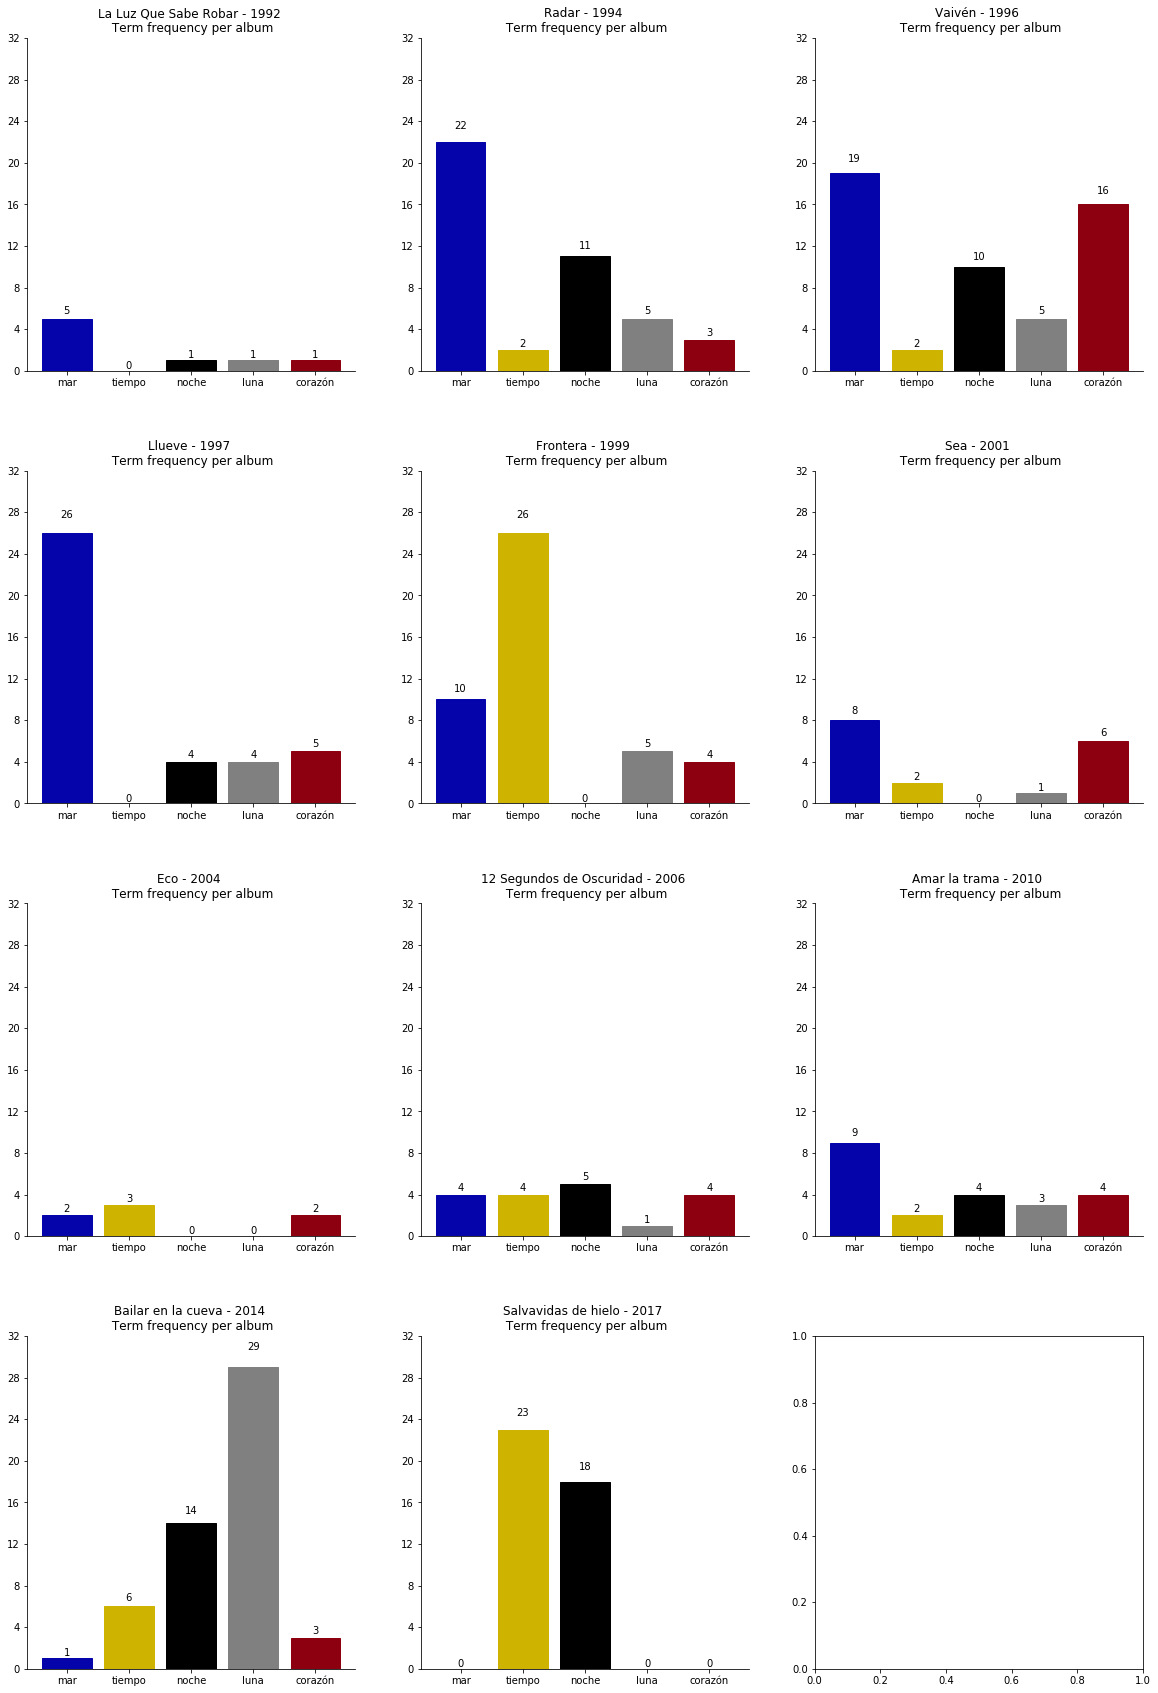

In [17]:
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))

for row in range(ROWS):
    for col in range(COLS):
        if not albums_ordered_by_year:
            break
            
        an_album_title = albums_ordered_by_year.pop(0)
        an_album_year = years_for_albums.pop(0)
        an_album = words_by_album[an_album_title]
        rects = axes[row, col].bar(range(len(an_album)), list(an_album.values()), align='center')
        axes[row, col].set_xticks(range(len(an_album)))
        axes[row, col].set_xticklabels(list(an_album.keys()))
        axes[row, col].yaxis.set_major_locator(MaxNLocator(integer=True))
        axes[row, col].set_ylim([0,max_appearance + 3])
        axes[row, col].set_title("%s - %d \n Term frequency per album" % (an_album_title, an_album_year))
        axes[row, col].spines['right'].set_visible(False)
        axes[row, col].spines['top'].set_visible(False)
        rects[0].set_color('xkcd:royal blue')
        rects[1].set_color('xkcd:mustard')
        rects[2].set_color('black')
        rects[3].set_color('grey')
        rects[4].set_color('xkcd:crimson')
        autolabel(rects, row, col)

plt.subplots_adjust(hspace = 0.3)
plt.show()

## Interesting insight:
    - He loved talking about the sea ('mar') in the 90's but grew bored as time passed by.
    - After a time in his albums where he doesn't revisit his favorite terms a lot, comes back to monothematic stuff.
    - Bailar en la cueva is super focused on the moon ('luna') and the night ('noche').
    - Salvavidas de hielo is about the pass of time ('tiempo'), a trend which he recovered from Frontera, and again, the night ('noche').

In [18]:
words_by_year = pd.DataFrame(words_by_year).transpose()

In [19]:
values_for_y_ticks = []
for a_word in words_by_year.columns:
    values_for_y_ticks.extend(words_by_year[a_word].unique())
values_for_y_ticks = list(set(values_for_y_ticks))

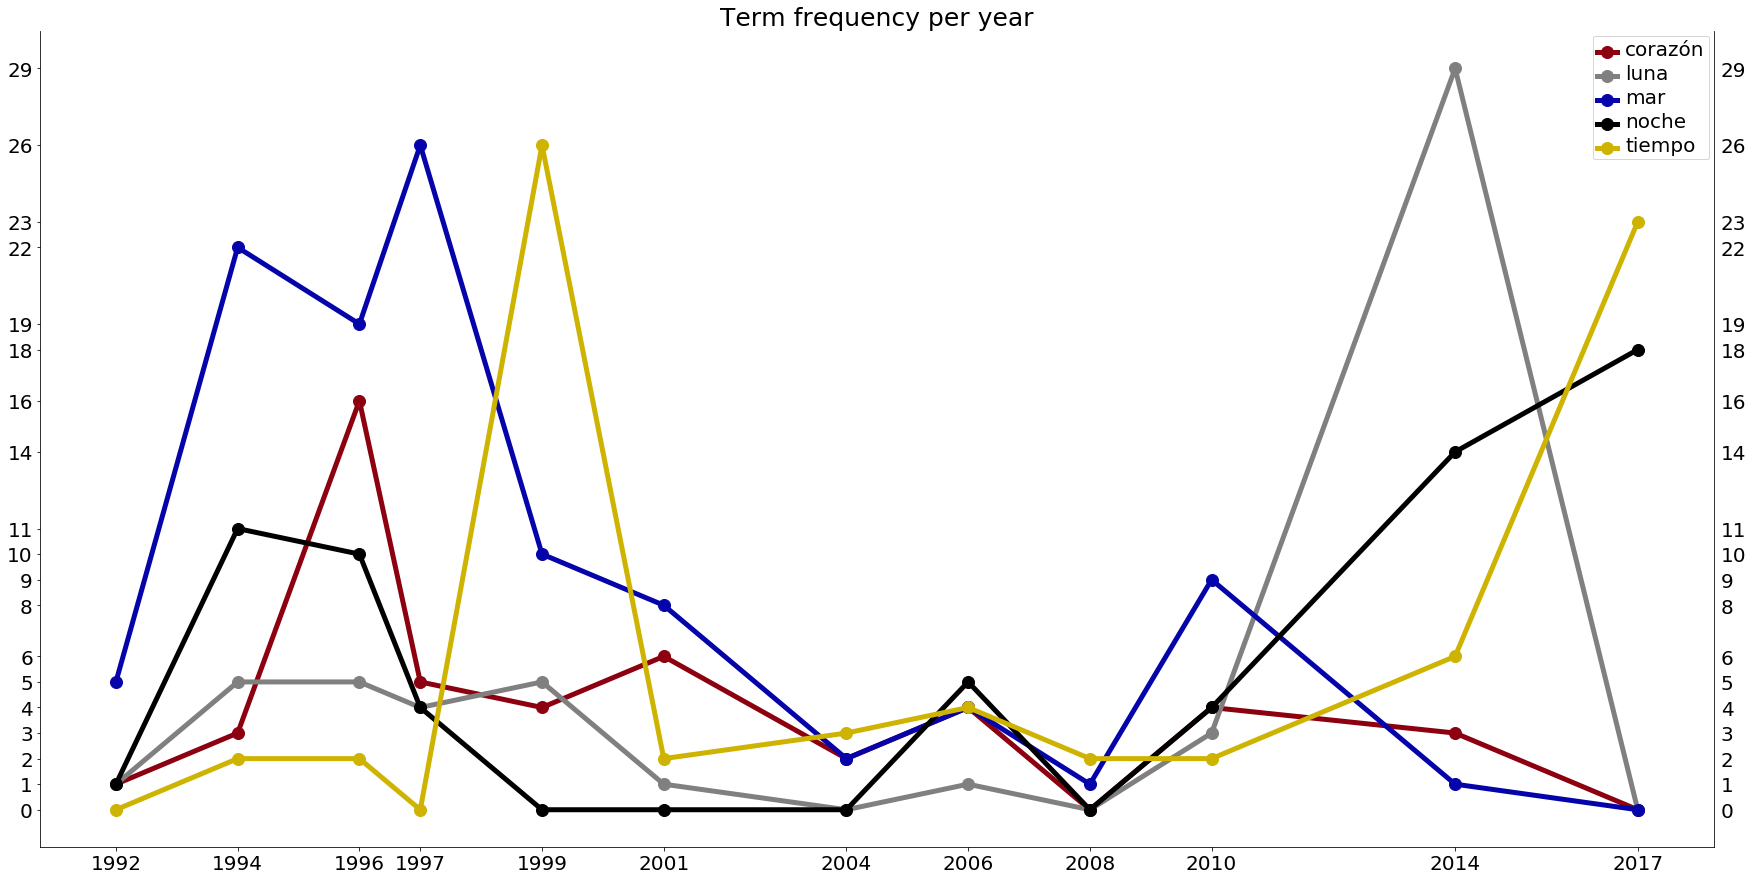

In [20]:
fig, ax = plt.subplots(figsize=(30,15))
for top_word in list(words_by_year.columns):
    ax.plot(
        words_by_year.index, 
        words_by_year[top_word], 
        '-', 
        color=colormap[top_word], 
        linewidth=5, 
        marker='o',
        markersize=12
    )
leg = plt.legend()
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(5)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize(20)
plt.xticks(words_by_year.index)
plt.yticks(values_for_y_ticks)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=20)
ax.set_title("Term frequency per year", fontdict={'fontsize': 25})
plt.show()

## Lets polish this

Future lines of work:

- http://www.everydayanalytics.ca/2013/06/radiohead-lyrics-data-visualization-and-content-analysis.html
- https://www.promptcloud.com/blog/data-visualization-text-mining-taylor-swift-song-lyrics
- https://medium.com/@krisshaffer/exploring-musical-data-with-r-an-introduction-to-computational-music-analysis-2216d061fed6 chords through spotify api?
- 

New try

In [21]:
df = pd.read_csv("data/drexler_final.csv", sep=';',index_col=0)

In [22]:
df.head()

,track_number,name,album,year,duplicated,duration_ms,duration_s,acousticness,danceability,energy,key,tempo,time_signature,valence,mode,lyrics
index,,,,,,,,,,,,,,,,
0,1,Movimiento,Salvavidas de hielo,2017,False,231653,23.165.333,0.900,0.784,0.457,2.0,125.021,4.0,0.546,1.0,Apenas nos pusimos en dos pies Comenzamos a mi...
1,2,Telefonía,Salvavidas de hielo,2017,False,184963,18.496.354,0.829,0.915,0.592,6.0,126.060,4.0,0.841,0.0,Que viva la telefonía En todas sus variantes P...
2,3,Silencio,Salvavidas de hielo,2017,False,207986,20.798.667,0.263,0.887,0.568,4.0,127.923,4.0,0.127,0.0,Todo el mundo intentando venderte algo Intenta...
3,4,Pongamos que hablo de Martínez,Salvavidas de hielo,2017,False,182453,18.245.333,0.893,0.849,0.458,9.0,119.950,4.0,0.461,1.0,"Fuimos cerrando, uno a uno cuatro bares Montev..."
4,5,Estalactitas,Salvavidas de hielo,2017,False,261066,26.106.667,0.797,0.772,0.630,0.0,136.019,4.0,0.909,1.0,El tiempo era entonces dinamita Vivíamos colga...


In [23]:
df['duration_s'] = df['duration_ms'] * 0.001
df['name'] = df['name'].str.replace(" \(feat.*$", "")

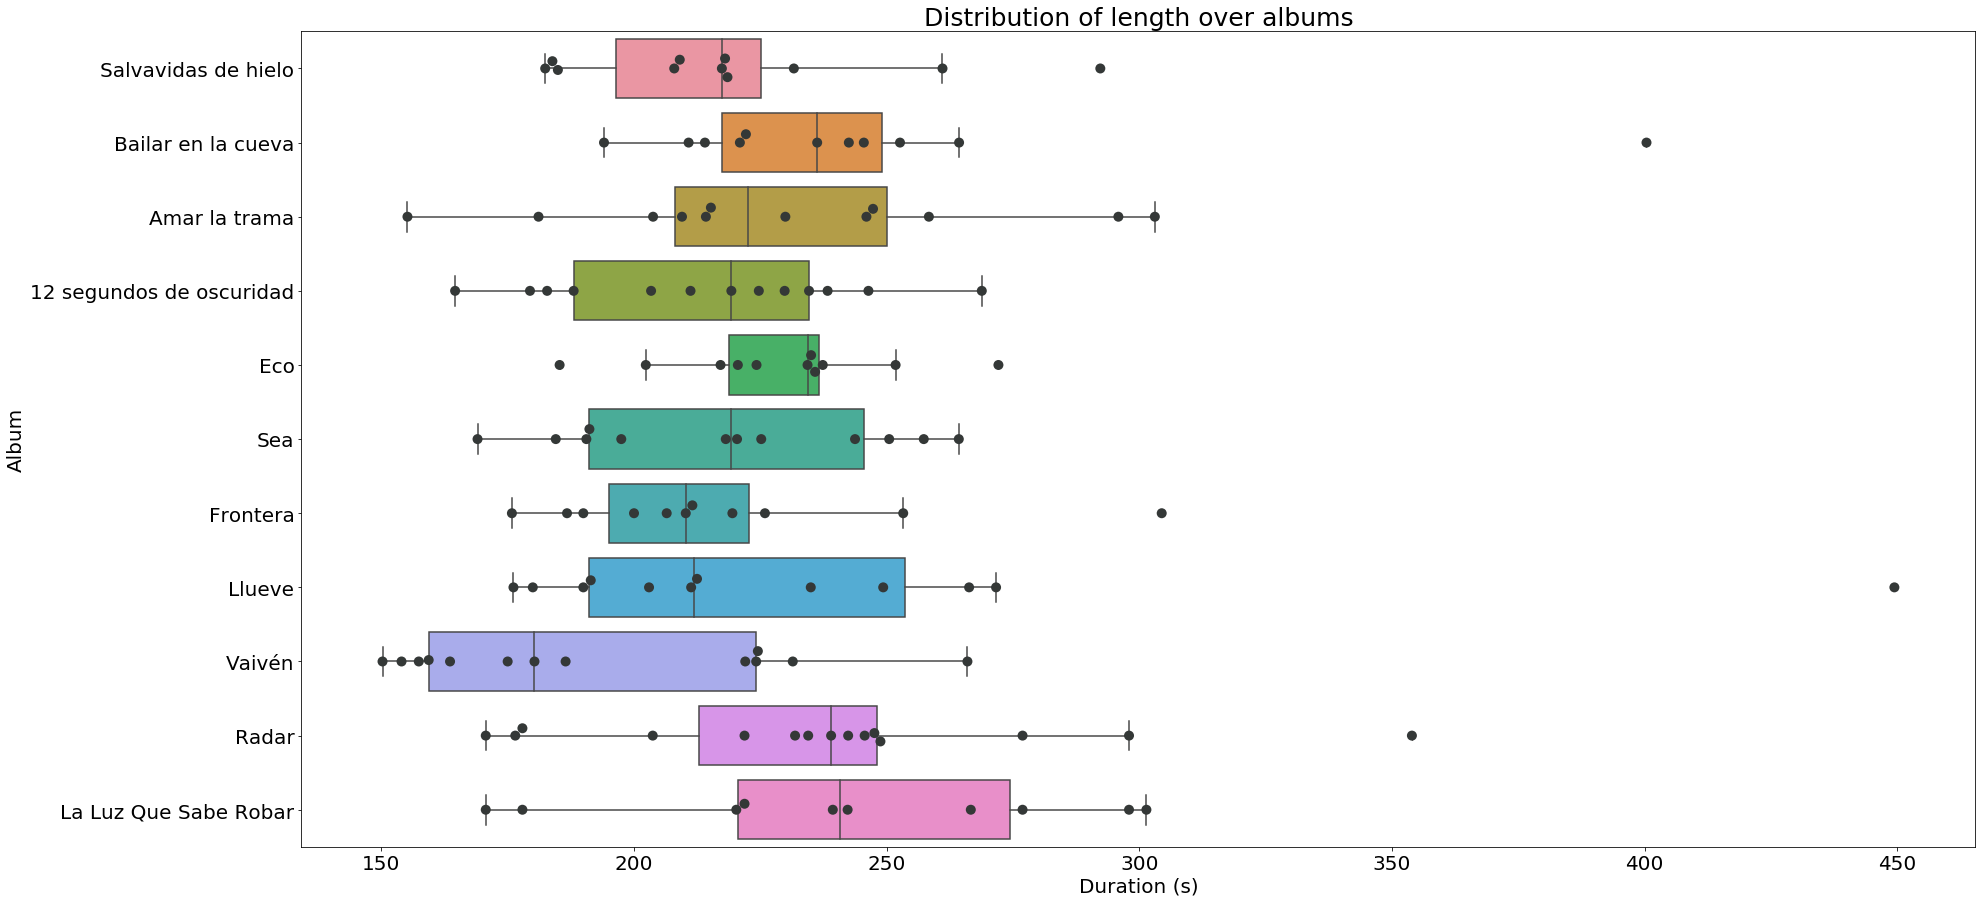

In [24]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="duration_s", y="album", data=df, orient='h')
ax = sns.swarmplot(x="duration_s", y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Duration (s)', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of length over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

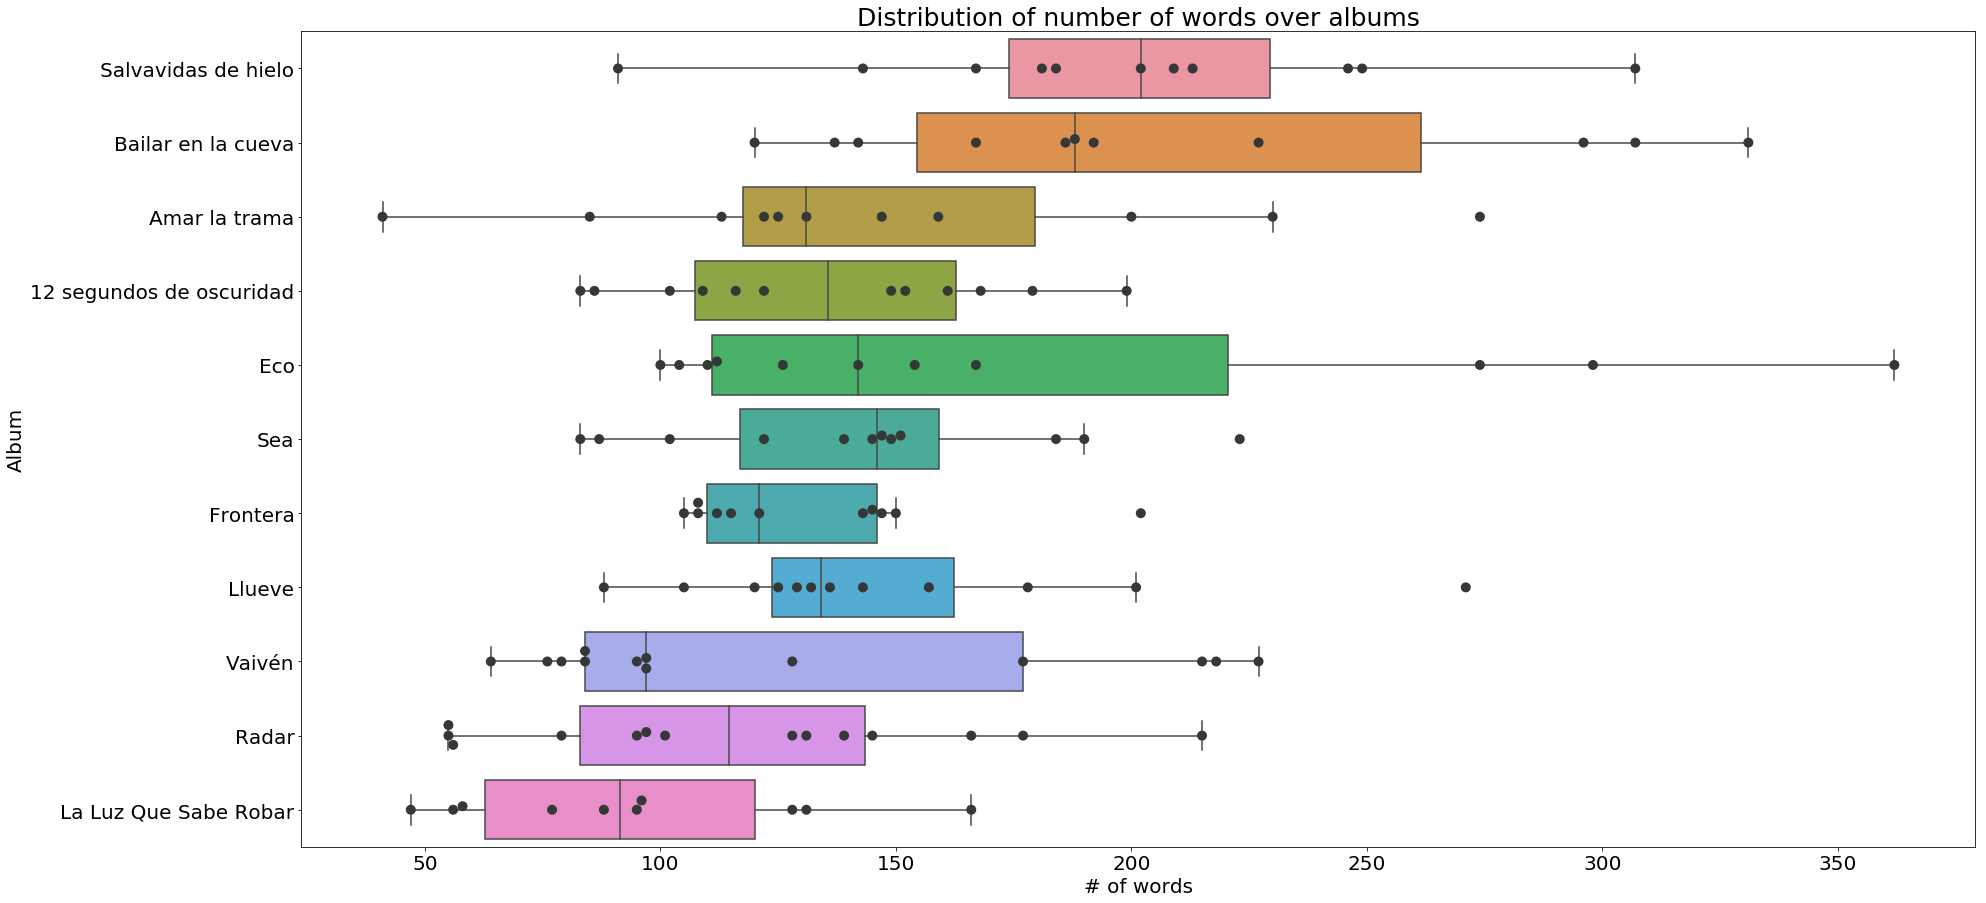

In [25]:
amount_of_words = df.lyrics.str.split().str.len()


fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x=amount_of_words, y="album", data=df, orient='h')
ax = sns.swarmplot(x=amount_of_words, y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('# of words', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of number of words over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

In [26]:
stopset = set(stopwords)
df['tokens'] = pd.Series(dtype=object)

In [27]:
for index, row in df.iterrows():
    try:
        tokens = word_tokenize(row['lyrics'])
        tokens_wo_stopwords = [word for word in tokens if not word in stopset]
        df.at[index, 'tokens'] = tokens_wo_stopwords
        df.at[index, 'le_d'] = ( len(tokens_wo_stopwords) / len(tokens) ) * 100
        df.at[index, 'ly_d'] = len(tokens) / row['duration_s']
        df.at[index, 'n_words'] = len(tokens)
        df.at[index, 'n_words_no_rep'] = len(list(set(tokens)))
    except: # songs without lyrics throw exceptions, i'm lazy
        continue

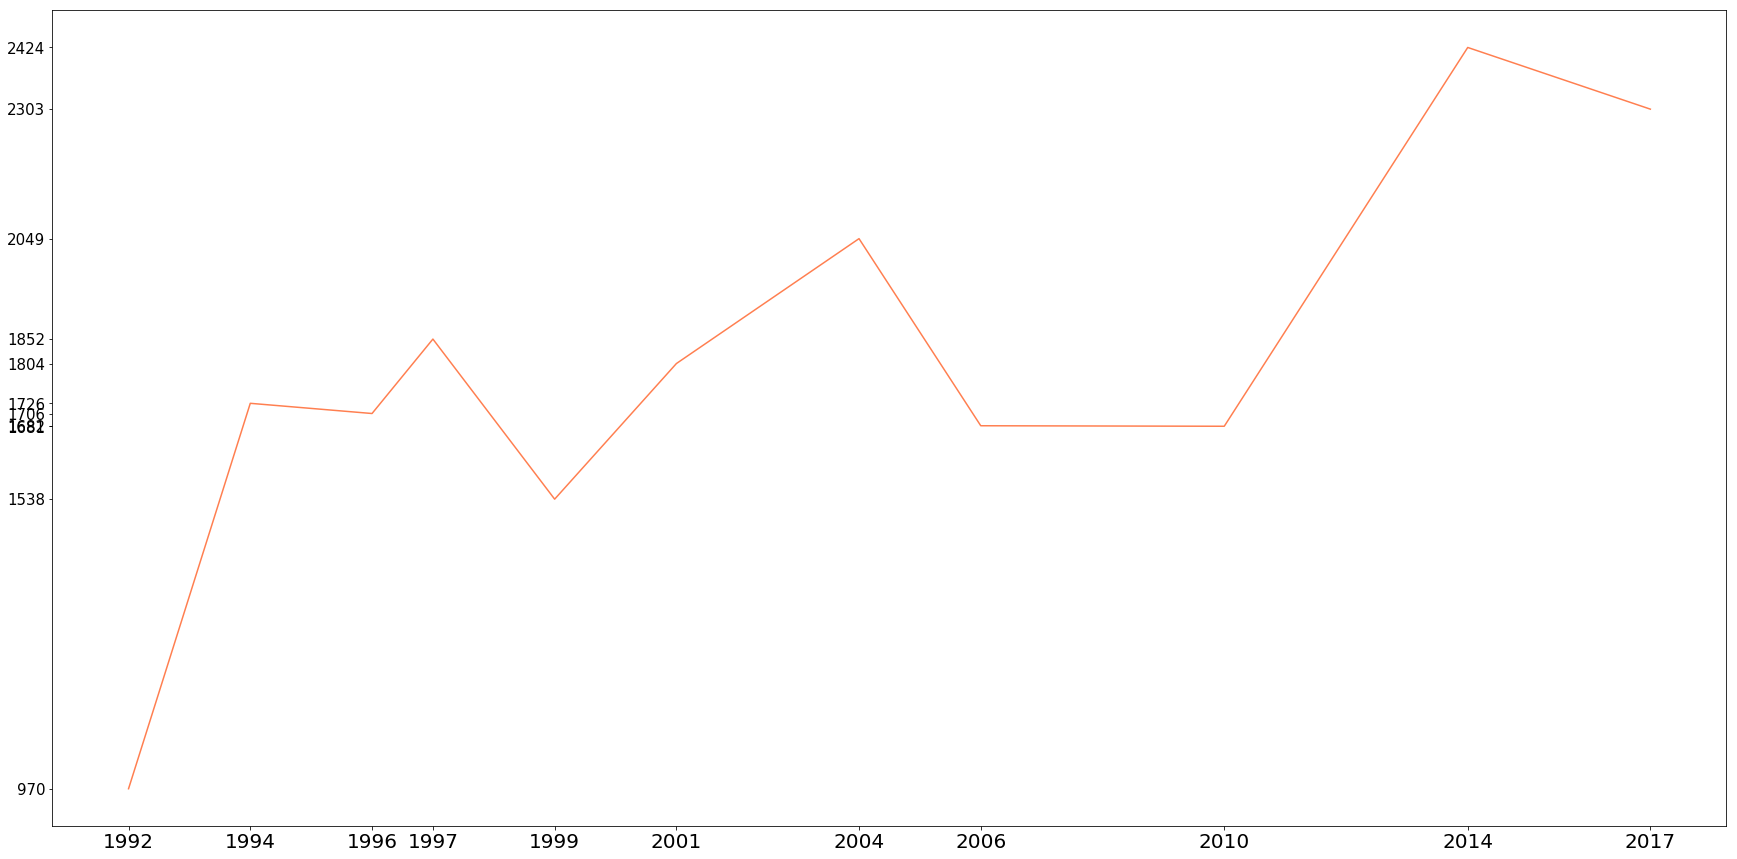

In [28]:
fig, ax = plt.subplots(figsize=(30,15))
n_words_by_album = df.groupby(["year"])['n_words'].sum()
ax = sns.lineplot(data=n_words_by_album, color="coral", legend=False, size=300)
plt.xticks(n_words_by_album.index)
plt.yticks(n_words_by_album)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.plot();

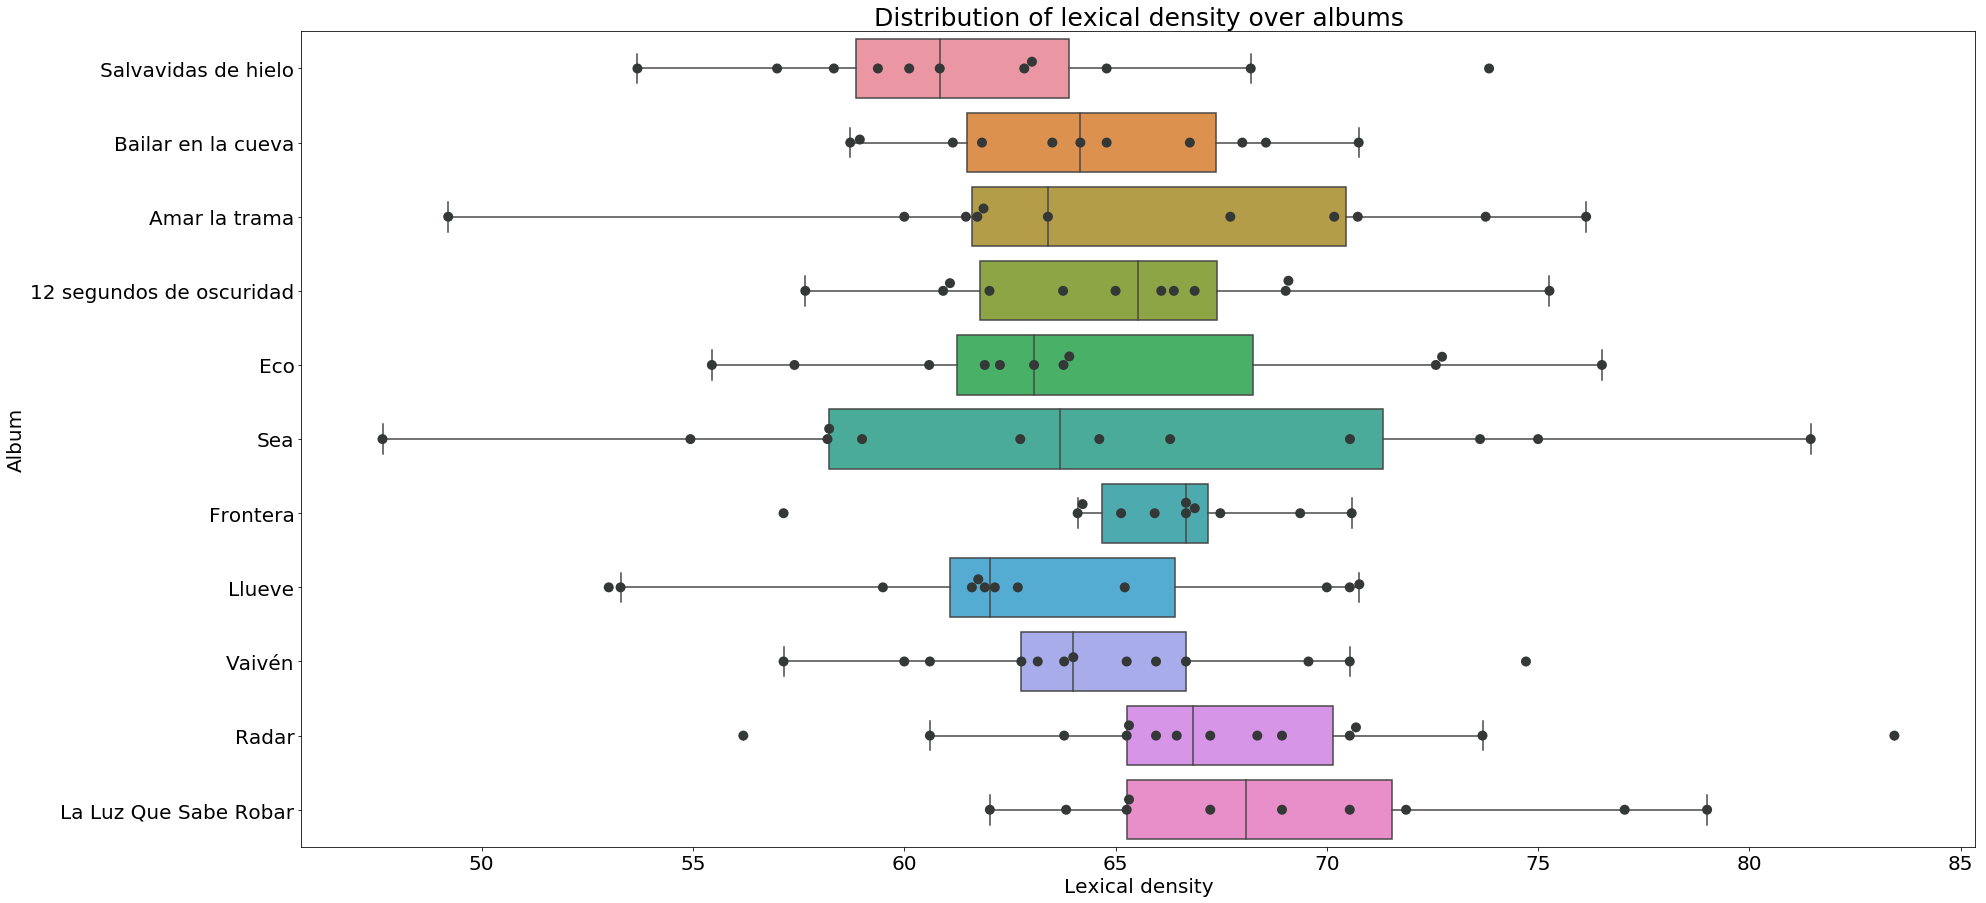

In [29]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="le_d", y="album", data=df, orient='h')
ax = sns.swarmplot(x="le_d", y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Lexical density', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of lexical density over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

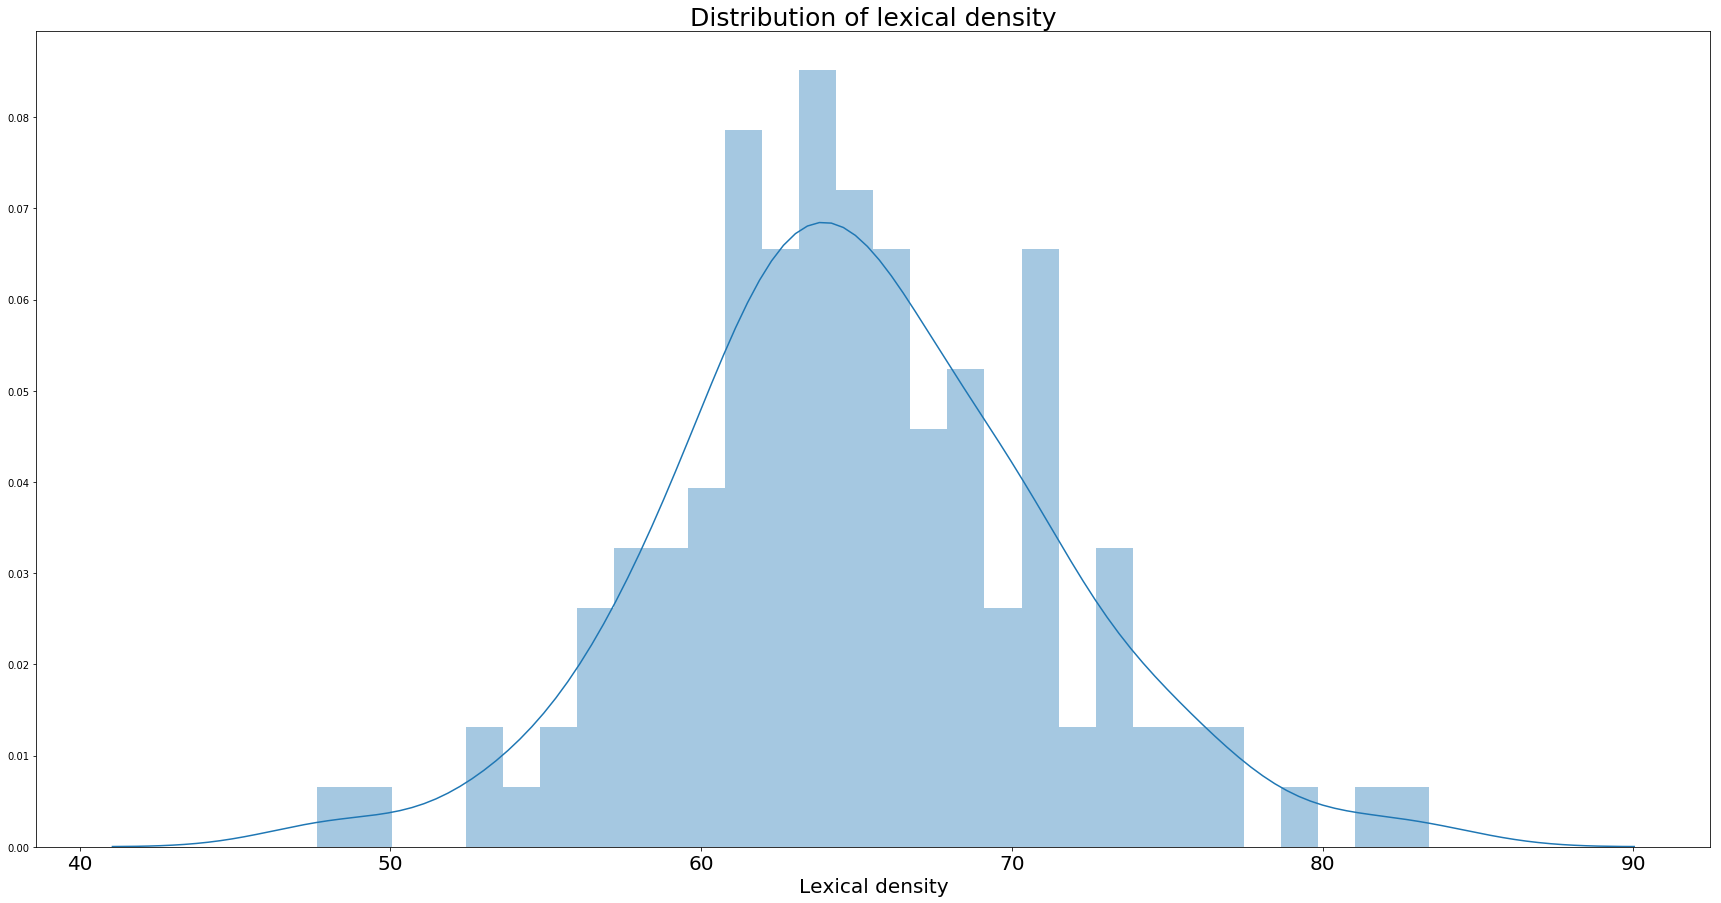

In [30]:
df['le_d'] = df['le_d'].fillna(0)

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.distplot(df[df['le_d'] > 0]['le_d'], bins=30)
plt.xlabel('Lexical density', fontsize=20)
plt.title('Distribution of lexical density', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();


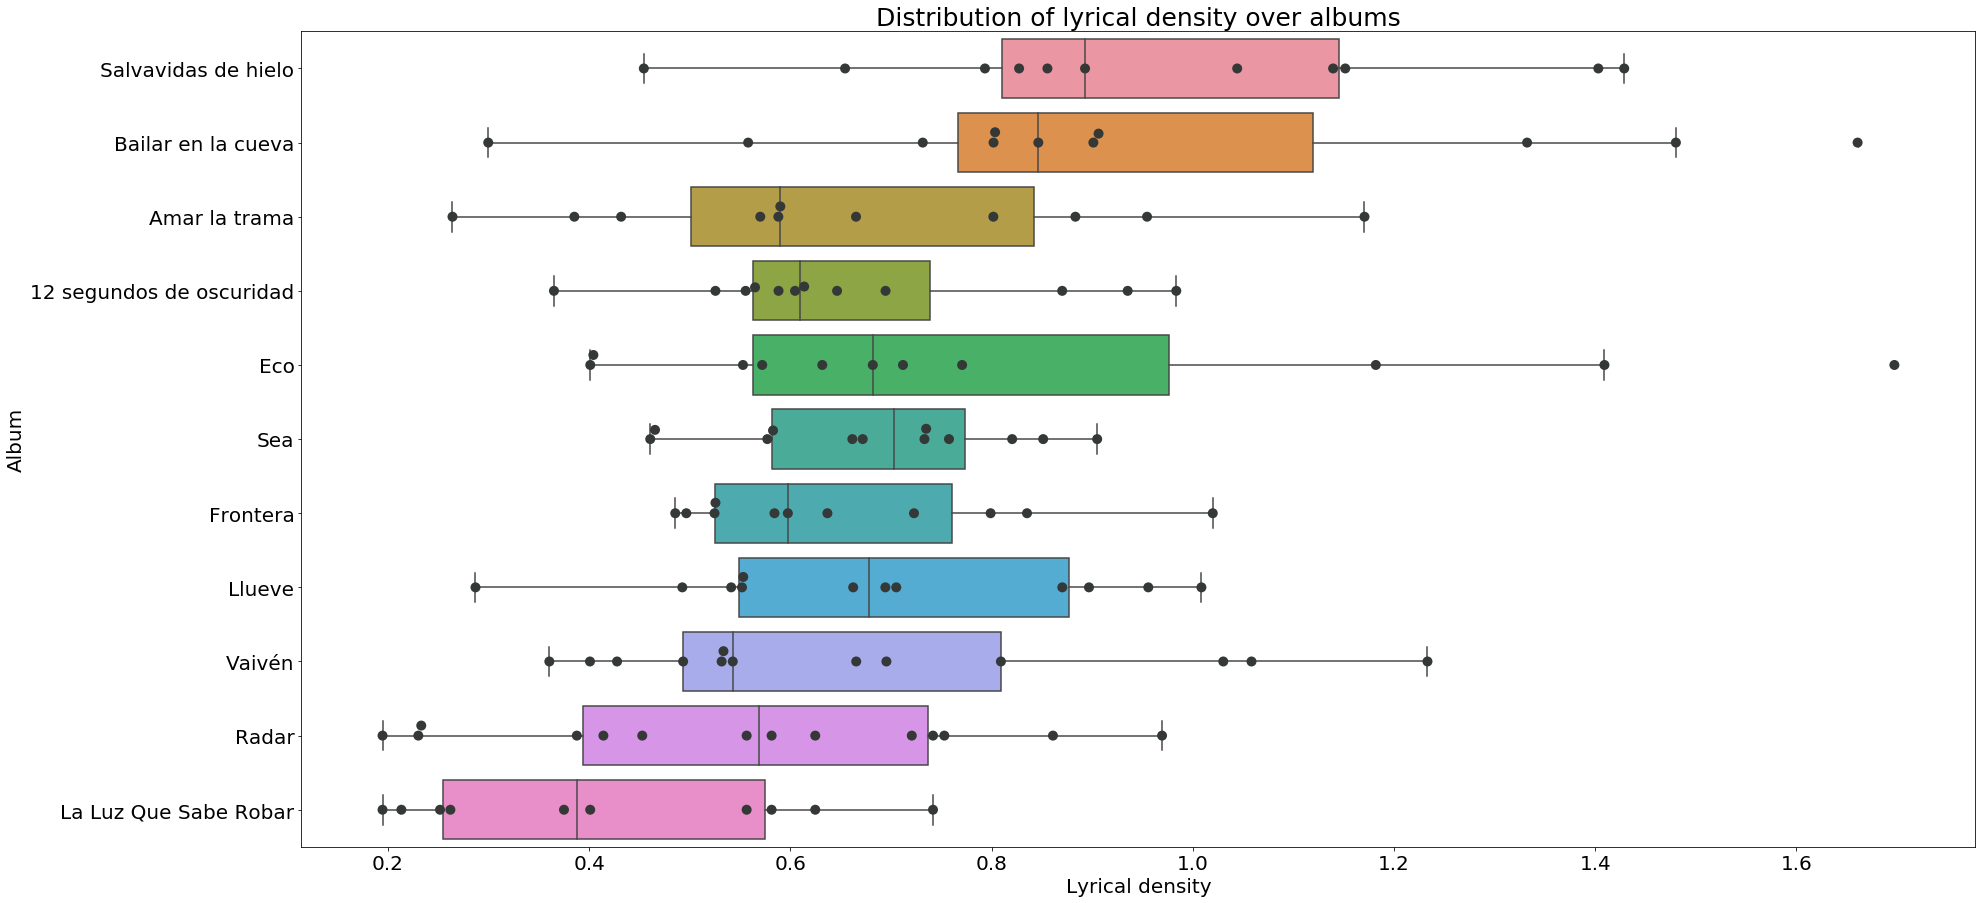

In [31]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="ly_d", y="album", data=df, orient='h')
ax = sns.swarmplot(x="ly_d", y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Lyrical density', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of lyrical density over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

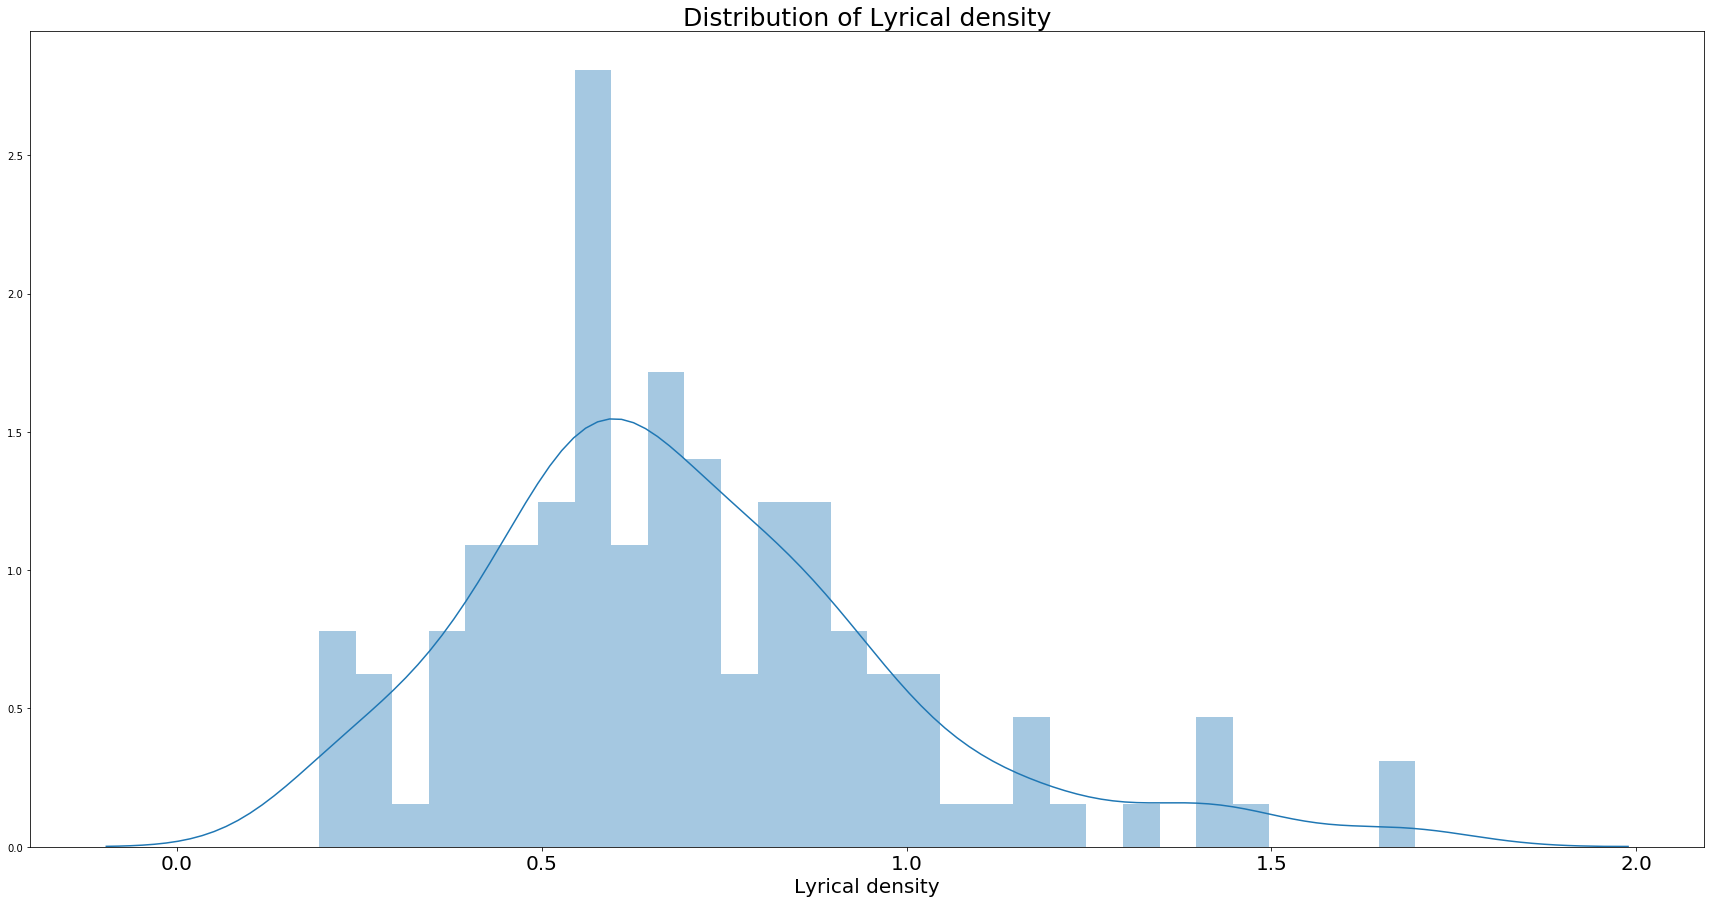

In [32]:
df['ly_d'] = df['ly_d'].fillna(0)

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.distplot(df[df['ly_d'] > 0]['ly_d'], bins=30)
plt.xlabel('Lyrical density', fontsize=20)
plt.title('Distribution of Lyrical density', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();


LE VS LY?


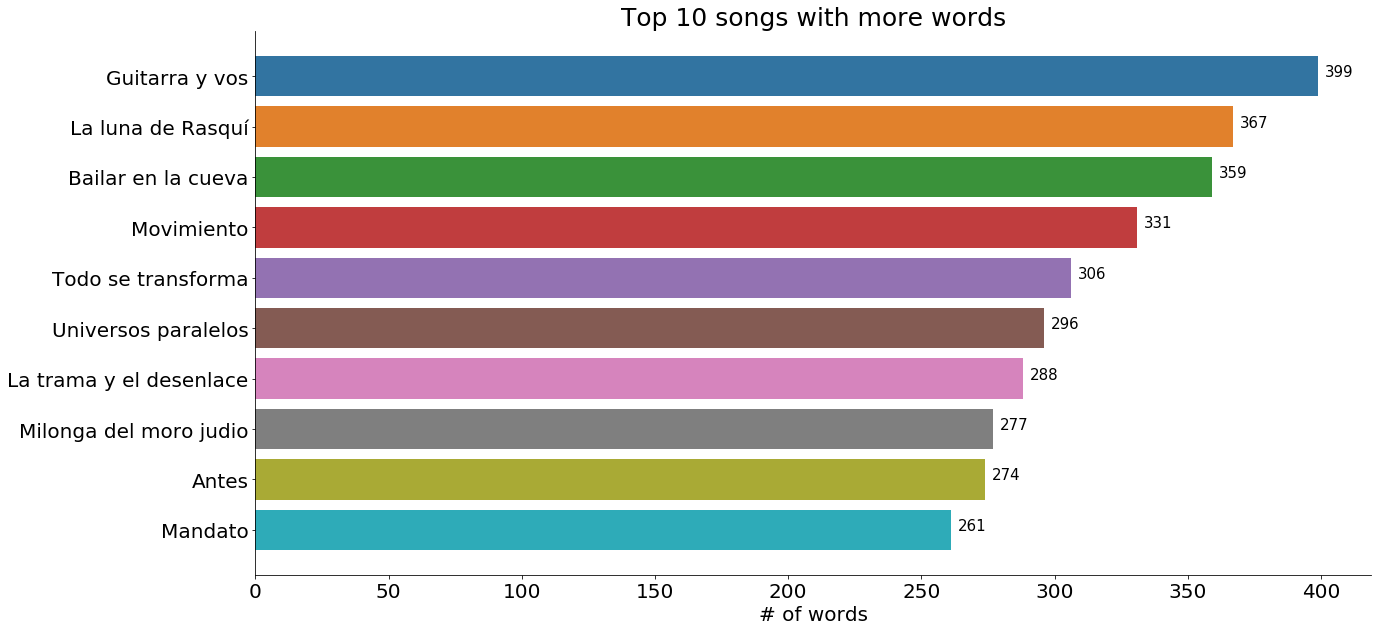

In [33]:
songs_with_more_words = df.sort_values("n_words", ascending=False)[:10]

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="n_words", y="name", data=songs_with_more_words)
plt.ylabel("")
plt.xlabel('# of words', fontsize=20)
plt.title('Top 10 songs with more words', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 8  ,
            p.get_y() + p.get_height()/2.,
            "%d" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

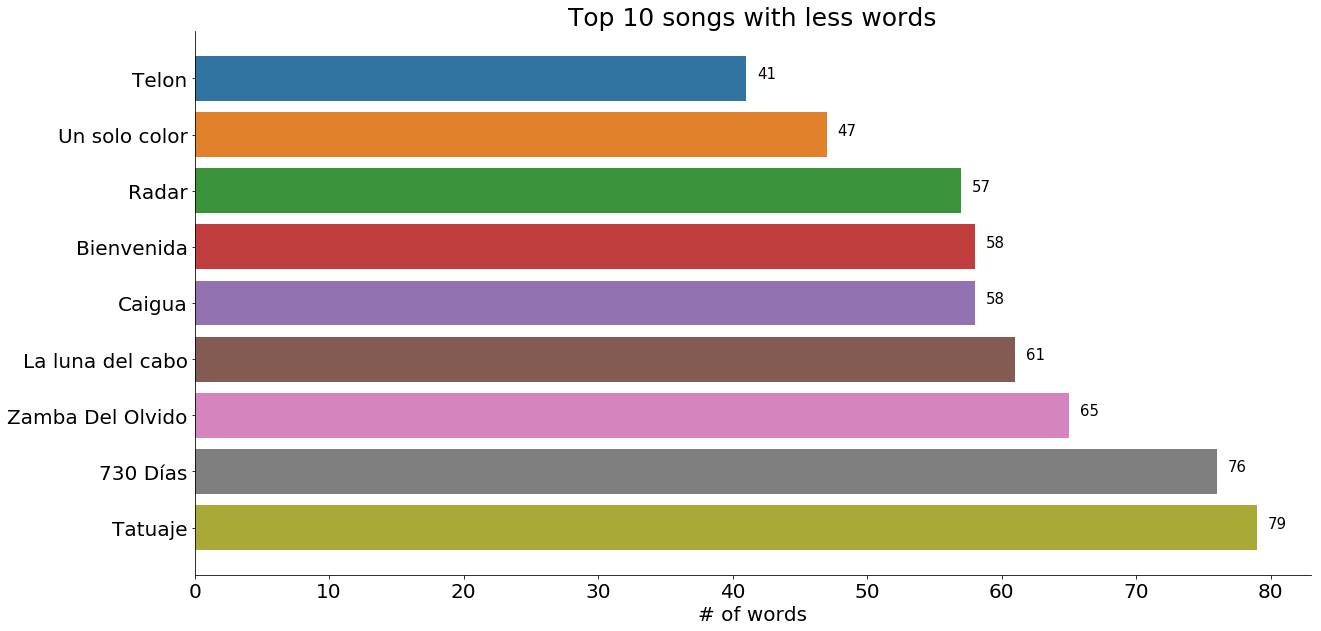

In [34]:
songs_with_less_words = df.sort_values("n_words")[:10]

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="n_words", y="name", data=songs_with_less_words)
plt.ylabel("")
plt.xlabel('# of words', fontsize=20)
plt.title('Top 10 songs with less words', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1.5  ,
            p.get_y() + p.get_height()/2.,
            "%d" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

In [35]:
stopset.add('na')
def make_corpora(a_series):
    corpora = []
    for a_sentence in a_series:
        try:
            new_lower_sentence = []
            for a_word in a_sentence:
                new_lower_sentence.append(a_word.lower())
            corpora.extend(new_lower_sentence)
        except:
            continue
    nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
    filtered = [w for w in corpora if nonPunct.match(w) and w not in stopset]
    counts = Counter(filtered)
    return counts

In [36]:
drexler_counts = make_corpora(df.tokens)
drexler_counts.most_common(10)

[('mar', 107),
 ('tiempo', 78),
 ('noche', 67),
 ('luna', 63),
 ('corazón', 55),
 ('bailar', 53),
 ('va', 50),
 ('dos', 48),
 ('si', 48),
 ('cada', 46)]

In [37]:
def plot_wordcloud_from_list(a_list):
    freqs_by_words = {}
    for a_topic_term in a_list:
        an_actual_word = a_topic_term[0]
        freqs_by_words[an_actual_word] = a_topic_term[1]
    # read the mask image
    trump_mask = np.array(Image.open("heart.jpg"))

    wc = WordCloud(background_color="white", max_words=2000, mask=trump_mask, max_font_size=100,)
    # generate word cloud
    wc.generate_from_frequencies(freqs_by_words)

    #show
    plt.figure(figsize=(20,20))
    plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()

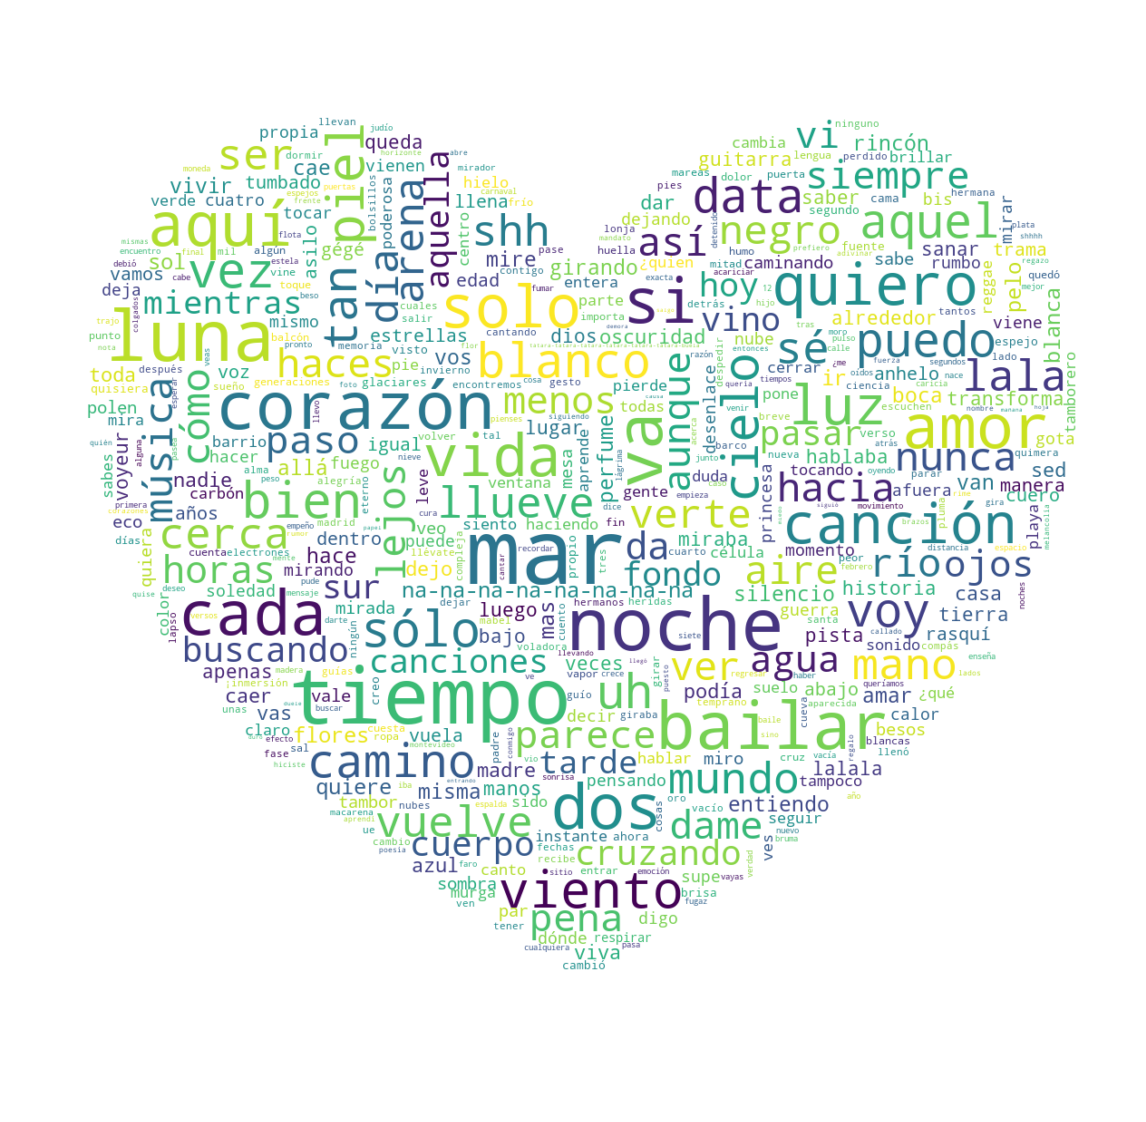

In [38]:
plot_wordcloud_from_list(drexler_counts.most_common(500))

# Sentiment analysis

In [39]:
lexicon = EmoLex('data/lexicon_spanish.txt')


Let's check the song "Transporte"

In [40]:
summary = lexicon.summarize_doc(df.loc[51].tokens)
summary

{'anger': 0.01818181818181818,
 'anticipation': 0.05454545454545454,
 'disgust': 0.0,
 'fear': 0.0,
 'joy': 0.07272727272727272,
 'negative': 0.0,
 'positive': 0.09090909090909091,
 'sadness': 0.0,
 'surprise': 0.05454545454545454,
 'trust': 0.03636363636363636}

In [41]:
df['anger'] = 0.0
df['anticipation'] = 0.0
df['disgust'] = 0.0
df['fear'] = 0.0
df['joy'] = 0.0
df['negative'] = 0.0
df['positive'] = 0.0
df['sadness'] = 0.0
df['surprise'] = 0.0
df['trust'] = 0.0

In [42]:
for index, _ in df.iterrows():
    try:
        to_lower = list(map(lambda x:x.lower(),df.loc[index].tokens))
        summary = lexicon.summarize_doc(to_lower)
        for key in summary.keys():
            df.at[index, key] = summary[key]
    except:
        continue

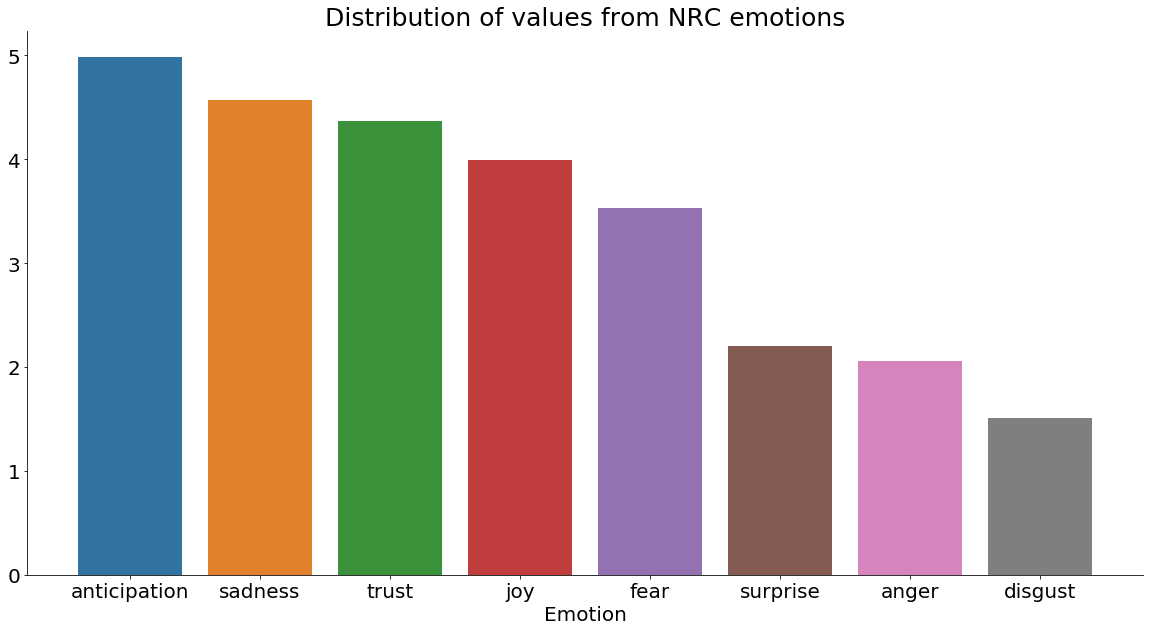

In [43]:
total_sentiments = pd.DataFrame(df.sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']].sort_values(ascending=False))
total_sentiments.columns = ['value']

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=total_sentiments.index, y='value', data=total_sentiments)
plt.ylabel("")
plt.xlabel('Emotion', fontsize=20)
plt.title('Distribution of values from NRC emotions', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
plt.plot();


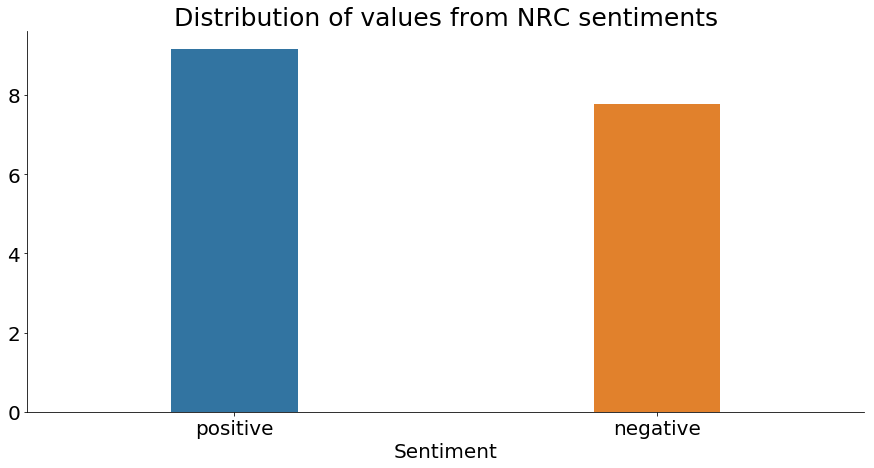

In [44]:
total_sentiment = pd.DataFrame(df.sum()[['positive', 'negative']])
total_sentiment.columns = ['value']

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.barplot(x=total_sentiment.index, y='value', data=total_sentiment)
plt.ylabel("")
plt.xlabel('Sentiment', fontsize=20)
plt.title('Distribution of values from NRC sentiments', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - .3

    # we change the bar width
    patch.set_width(.3)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)
sns.despine()
plt.plot();


In [45]:
columns = ['word','fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust', 'positive', 'negative']

In [46]:
word_appearances_by_sentiment = pd.DataFrame(columns=columns)
for index, _ in df.iterrows():
    try:
        to_lower = list(map(lambda x:x.lower(),df.loc[index].tokens))
        annotation = lexicon.annotate_doc(to_lower)
        for token, a_set in zip(to_lower, annotation):
            row = [token] + [x in a_set for x in columns[1:]]
            appending_df = pd.DataFrame([row], columns=columns)
            word_appearances_by_sentiment = word_appearances_by_sentiment.append(appending_df)
    except:
        continue
word_appearances_by_sentiment = word_appearances_by_sentiment.groupby("word").agg(
    {'anger': np.sum,
     'anticipation': np.sum,
     'disgust': np.sum,
     'fear': np.sum,
     'joy': np.sum,
     'negative': np.sum,
     'positive': np.sum,
     'sadness': np.sum,
     'surprise': np.sum,
     'trust': np.sum}
)

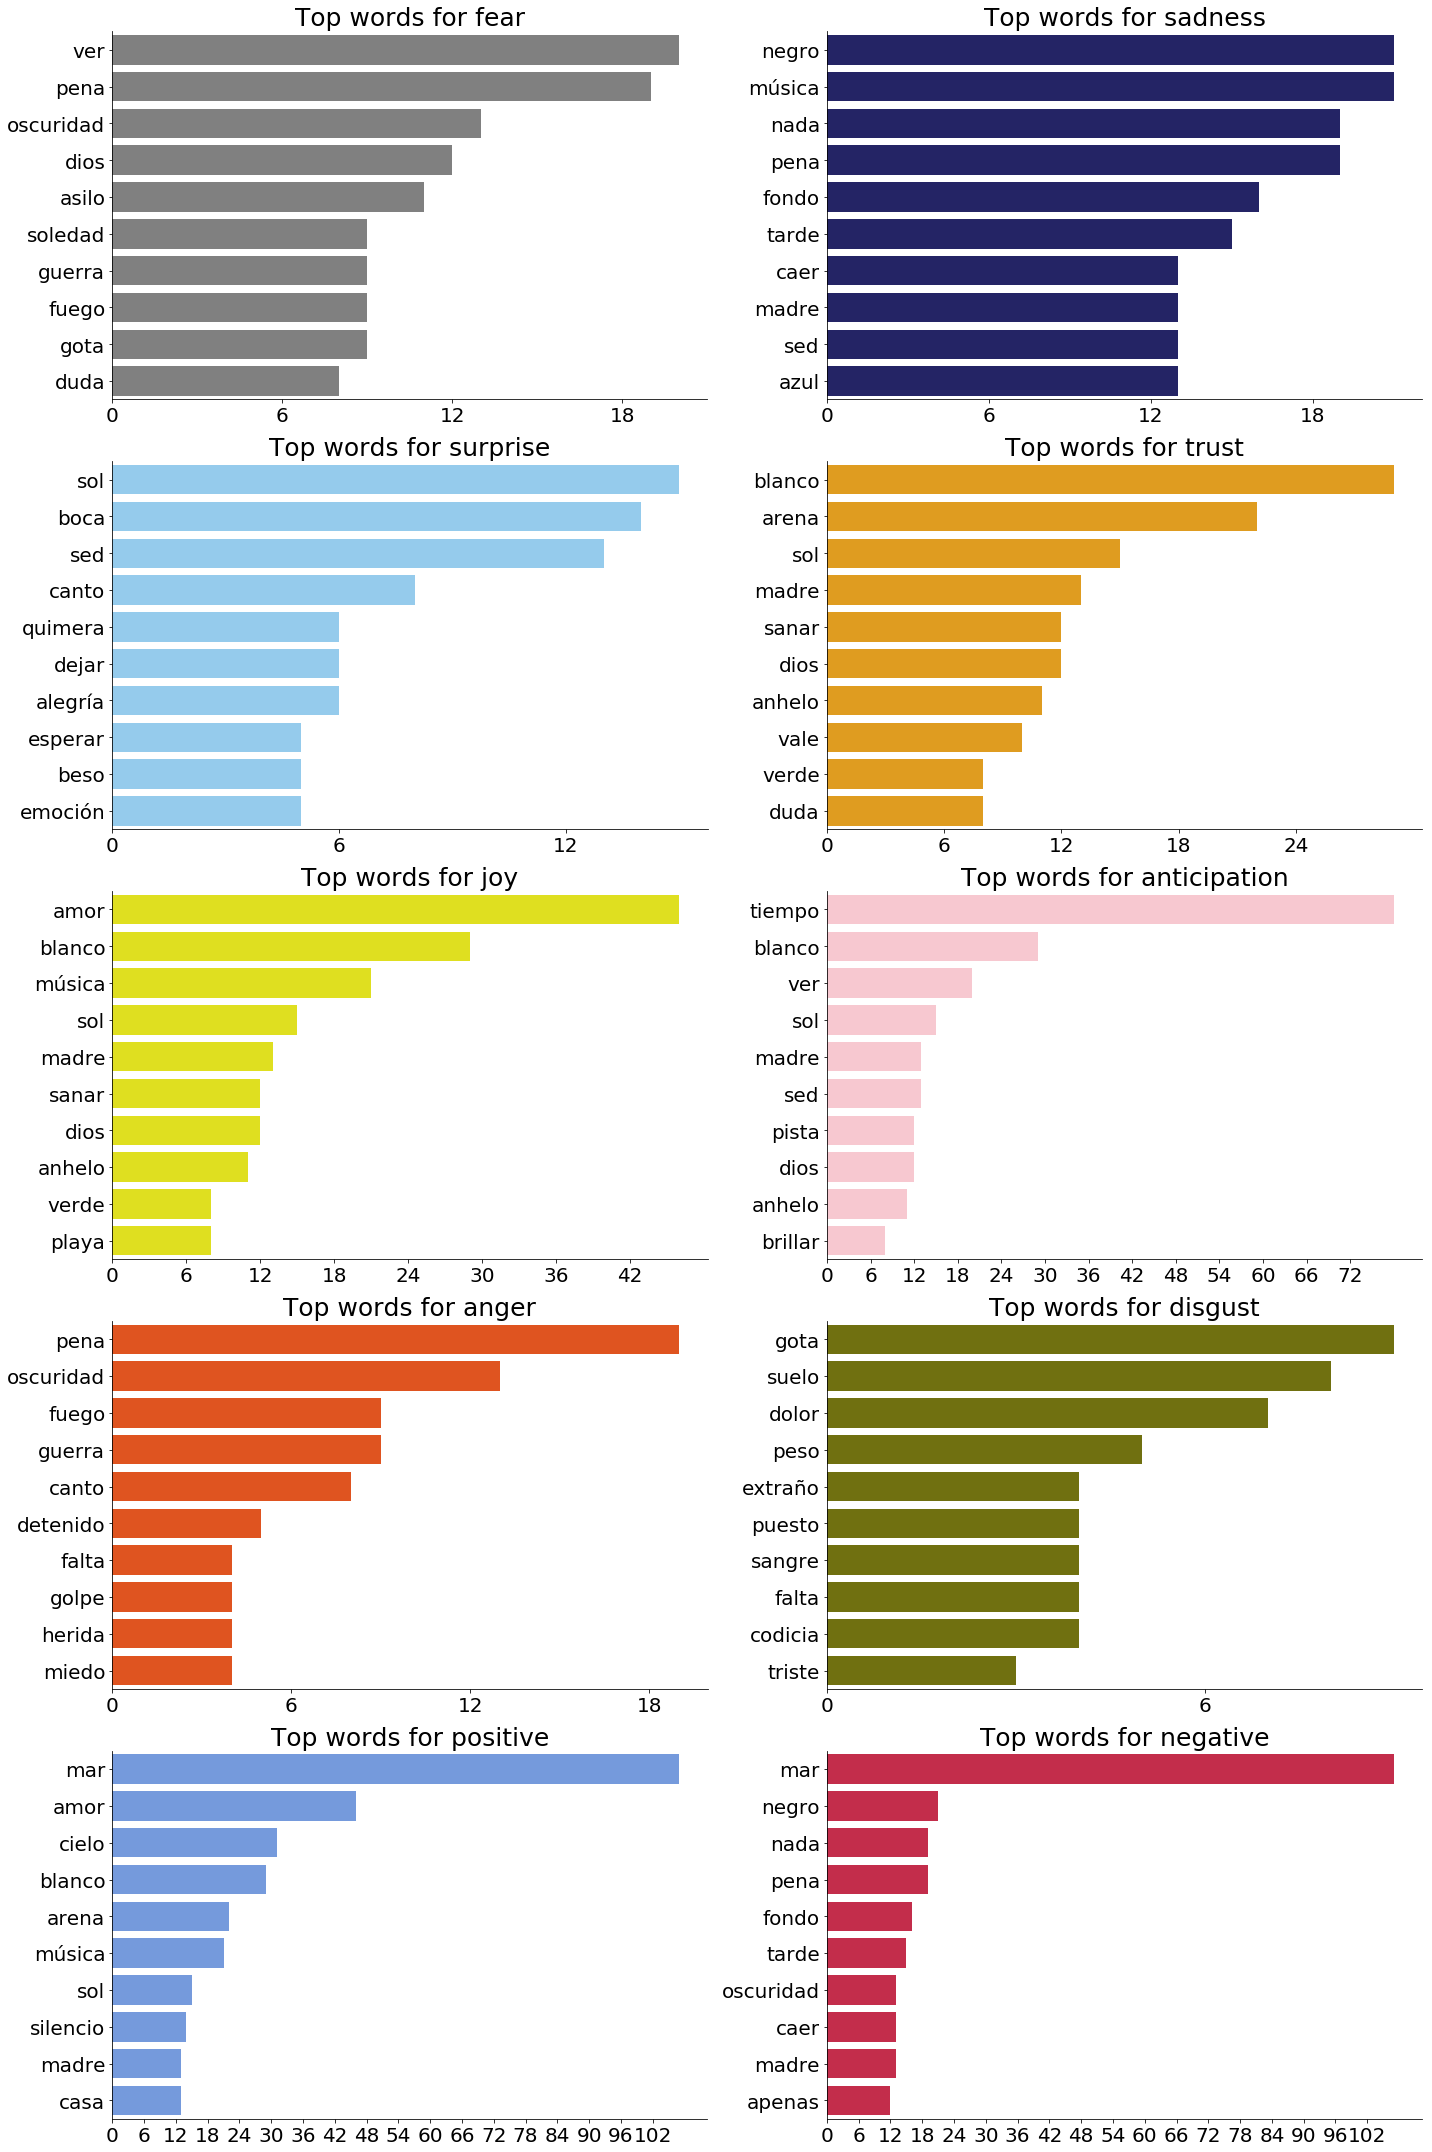

In [47]:
ROWS = 5
COLS = 2
cols_to_iterate = columns[1:]
colors = ['grey', 'midnightblue', 'lightskyblue', 'orange', 'yellow', 'pink', 'orangered', 'olive', 'cornflowerblue', 'crimson']
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        a_column = cols_to_iterate.pop(0)
        a_color = colors.pop(0)
        a_df = pd.DataFrame(word_appearances_by_sentiment.sort_values(by=[a_column], ascending=False)[a_column][:10])
        a_df.columns = ['count']
        sns.barplot(a_df['count'], a_df.index,orient='h', color=a_color, ax=axes[row, col])
        axes[row, col].set_title('Top words for %s' % a_column, fontsize=25)
        axes[row, col].set_xticks(range(0,max(a_df['count']), 6))
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
plt.tight_layout()
plt.show()

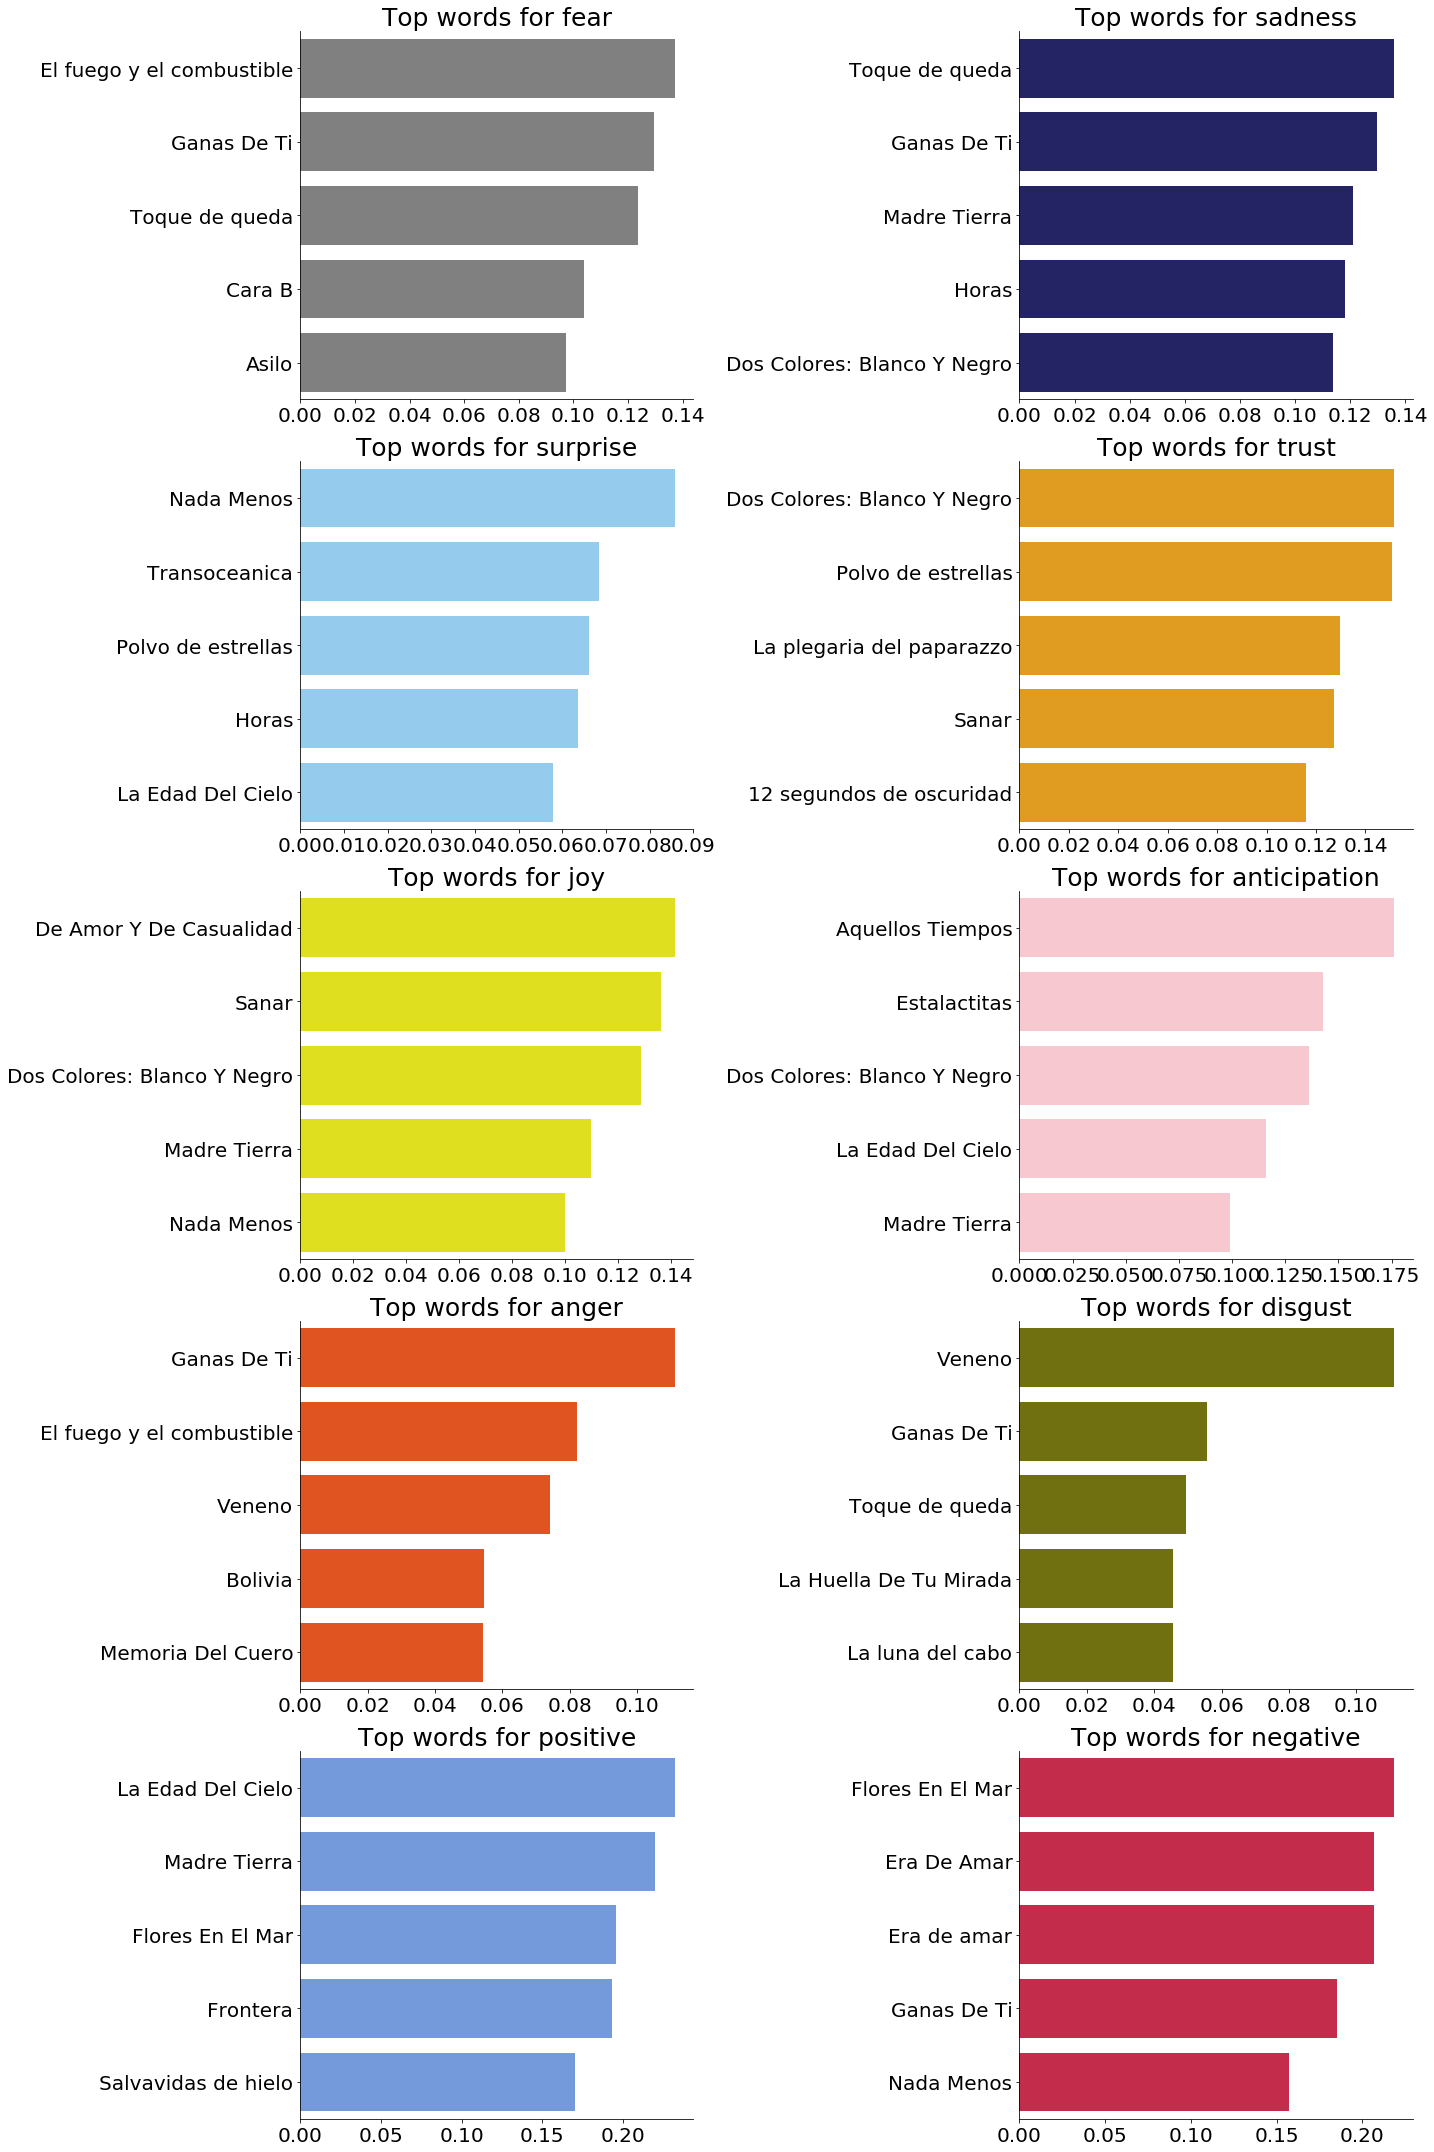

In [48]:
ROWS = 5
COLS = 2
cols_to_iterate = columns[1:]
colors = ['grey', 'midnightblue', 'lightskyblue', 'orange', 'yellow', 'pink', 'orangered', 'olive', 'cornflowerblue', 'crimson']
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        a_column = cols_to_iterate.pop(0)
        a_color = colors.pop(0)
        a_df = pd.DataFrame(df.sort_values(by=[a_column], ascending=False)[['name',a_column]][:5])
        sns.barplot(a_df[a_column], a_df.name, orient='h', color=a_color, ax=axes[row, col])
        axes[row, col].set_title('Top words for %s' % a_column, fontsize=25)
        #axes[row, col].set_xticks(range(0,max(a_df[a_column]), 6))
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
fig.tight_layout()
plt.show()

In [49]:
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]
years_for_albums = [
    1992, 1994, 1996, 1997, 1999, 
    2001, 2004, 2006, 2010, 2014, 
    2017
]

colormap = {
    'fear': 'grey', 
    'sadness': 'midnightblue', 
    'surprise': 'lightskyblue', 
    'trust': 'orange', 
    'joy': 'yellow', 
    'anticipation': 'pink', 
    'anger': 'orangered', 
    'disgust': 'olive', 
    'positive': 'cornflowerblue', 
    'negative': 'crimson'
}


emotions=['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']
sentiments=['positive', 'negative']
albums_by_emotion = pd.DataFrame(columns=['album', 'year'] + emotions + sentiments)

for an_album, a_year in zip(albums_ordered_by_year, years_for_albums):
    some_albums_emotions = pd.DataFrame(df[df['album'] == an_album].sum()[emotions])
    some_albums_sentiments = pd.DataFrame(df[df['album'] == an_album].sum()[sentiments])
    row = [an_album, a_year] + list(some_albums_emotions[0].values) + list(some_albums_sentiments[0].values)
    appending_df = pd.DataFrame([row], columns=['album', 'year'] + emotions + sentiments)
    albums_by_emotion = albums_by_emotion.append(appending_df)
albums_by_emotion = albums_by_emotion.reset_index(drop=True)
albums_by_emotion

,album,year,fear,sadness,surprise,trust,joy,anticipation,anger,disgust,positive,negative
0,La Luz Que Sabe Robar,1992,0.203686,0.385296,0.155135,0.284536,0.358232,0.357719,0.178083,0.156379,0.603337,0.436929
1,Radar,1994,0.276221,0.539762,0.248387,0.342851,0.393322,0.522680,0.209822,0.181305,1.055875,0.946799
2,Vaivén,1996,0.374724,0.719195,0.143359,0.381474,0.361346,0.534869,0.251901,0.135175,0.979585,1.029696
3,Llueve,1997,0.320040,0.340336,0.090775,0.304329,0.382169,0.357141,0.185393,0.143208,0.941885,0.860252
4,Frontera,1999,0.362460,0.403787,0.211708,0.432888,0.424484,0.705346,0.217928,0.125652,1.195333,0.697377
5,Sea,2001,0.276593,0.386082,0.303028,0.481634,0.435938,0.309596,0.132745,0.090931,0.876404,0.704091
6,Eco,2004,0.278267,0.300399,0.328133,0.528648,0.468932,0.442141,0.202439,0.142790,0.787769,0.548452
7,12 segundos de oscuridad,2006,0.441877,0.487261,0.138745,0.526699,0.306674,0.377294,0.252825,0.141355,0.654582,0.744588
8,Amar la trama,2010,0.377031,0.430701,0.179193,0.290156,0.213433,0.387376,0.130580,0.110726,0.528819,0.735744
9,Bailar en la cueva,2014,0.290060,0.309666,0.171506,0.455471,0.330000,0.410849,0.187282,0.197405,0.746761,0.624168


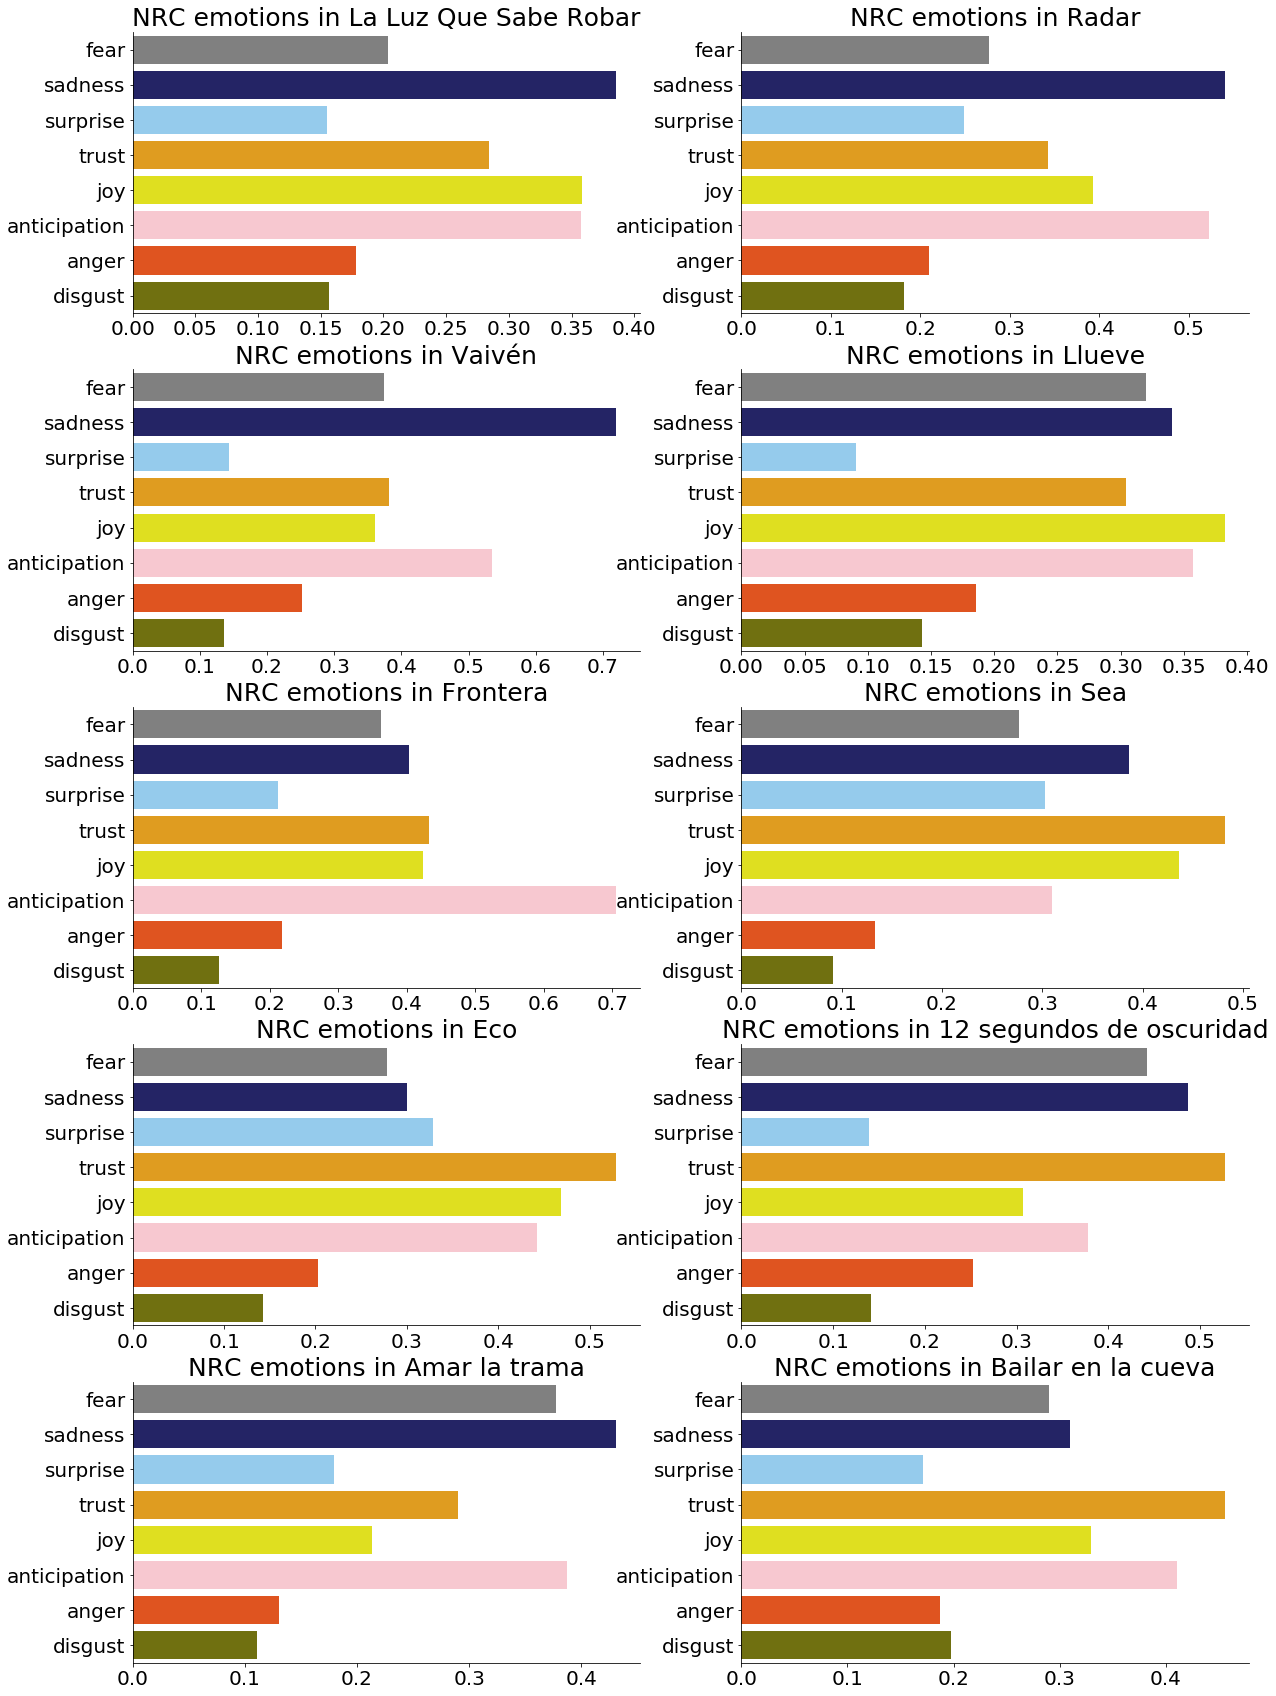

In [50]:
ROWS = 5
COLS = 2
cols_to_iterate = albums_ordered_by_year
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        an_album = cols_to_iterate.pop(0)
        
        total_sentiments = pd.DataFrame(df[df['album'] == an_album].sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']])
        total_sentiments.columns = ['value']
        sns.barplot(
            y=total_sentiments.index, 
            x='value', 
            orient='h', 
            data=total_sentiments, 
            ax=axes[row, col], 
            #hue=total_sentiments.index,
            palette=colormap
        )

        axes[row, col].set_title('NRC emotions in %s' % an_album, fontsize=25)
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
plt.show()


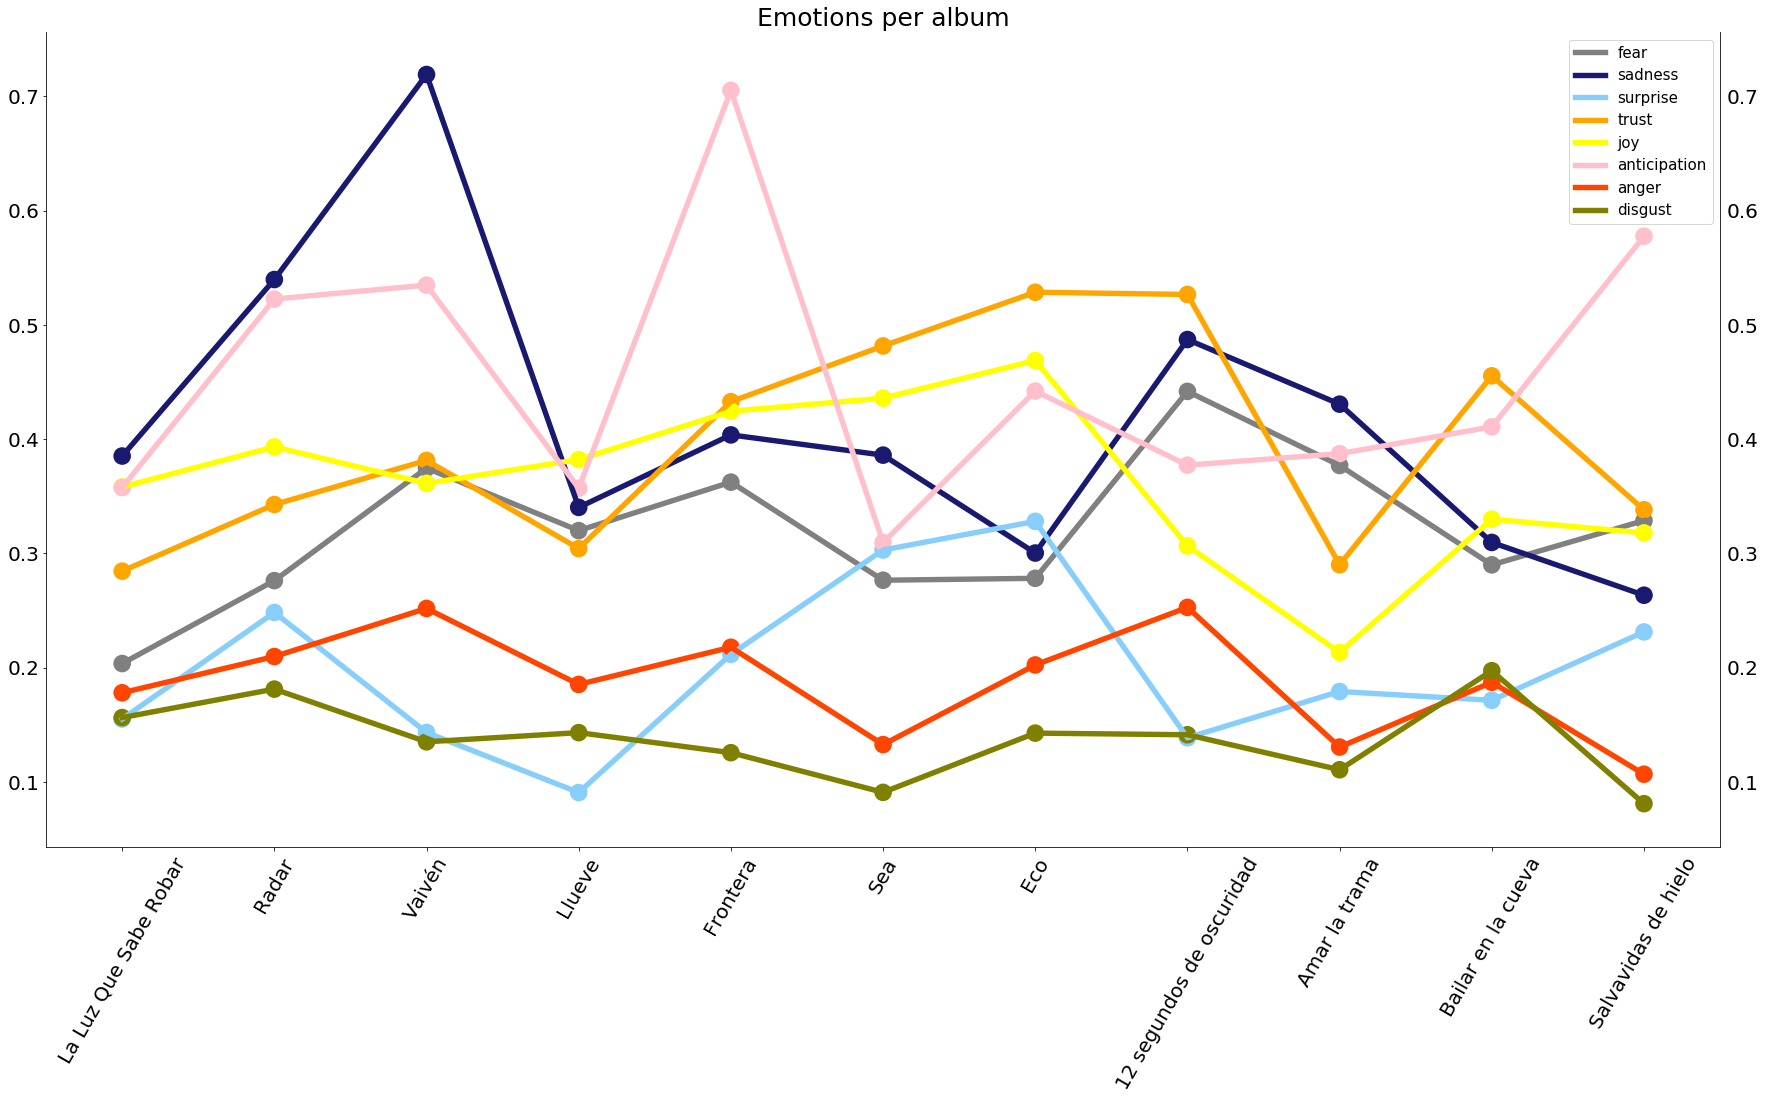

In [51]:
fig, ax = plt.subplots(figsize=(30,15))
for an_emotion in emotions:
    sns.pointplot(x="album", y=an_emotion, data=albums_by_emotion, color=colormap[an_emotion], scale=2,)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=20)
ax.set_title("Emotions per album", fontdict={'fontsize': 25})
plt.ylabel("")
plt.xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax.legend(handles=ax.lines[::len(albums_by_emotion)+1], labels=emotions, prop={'size': 15})
plt.show();

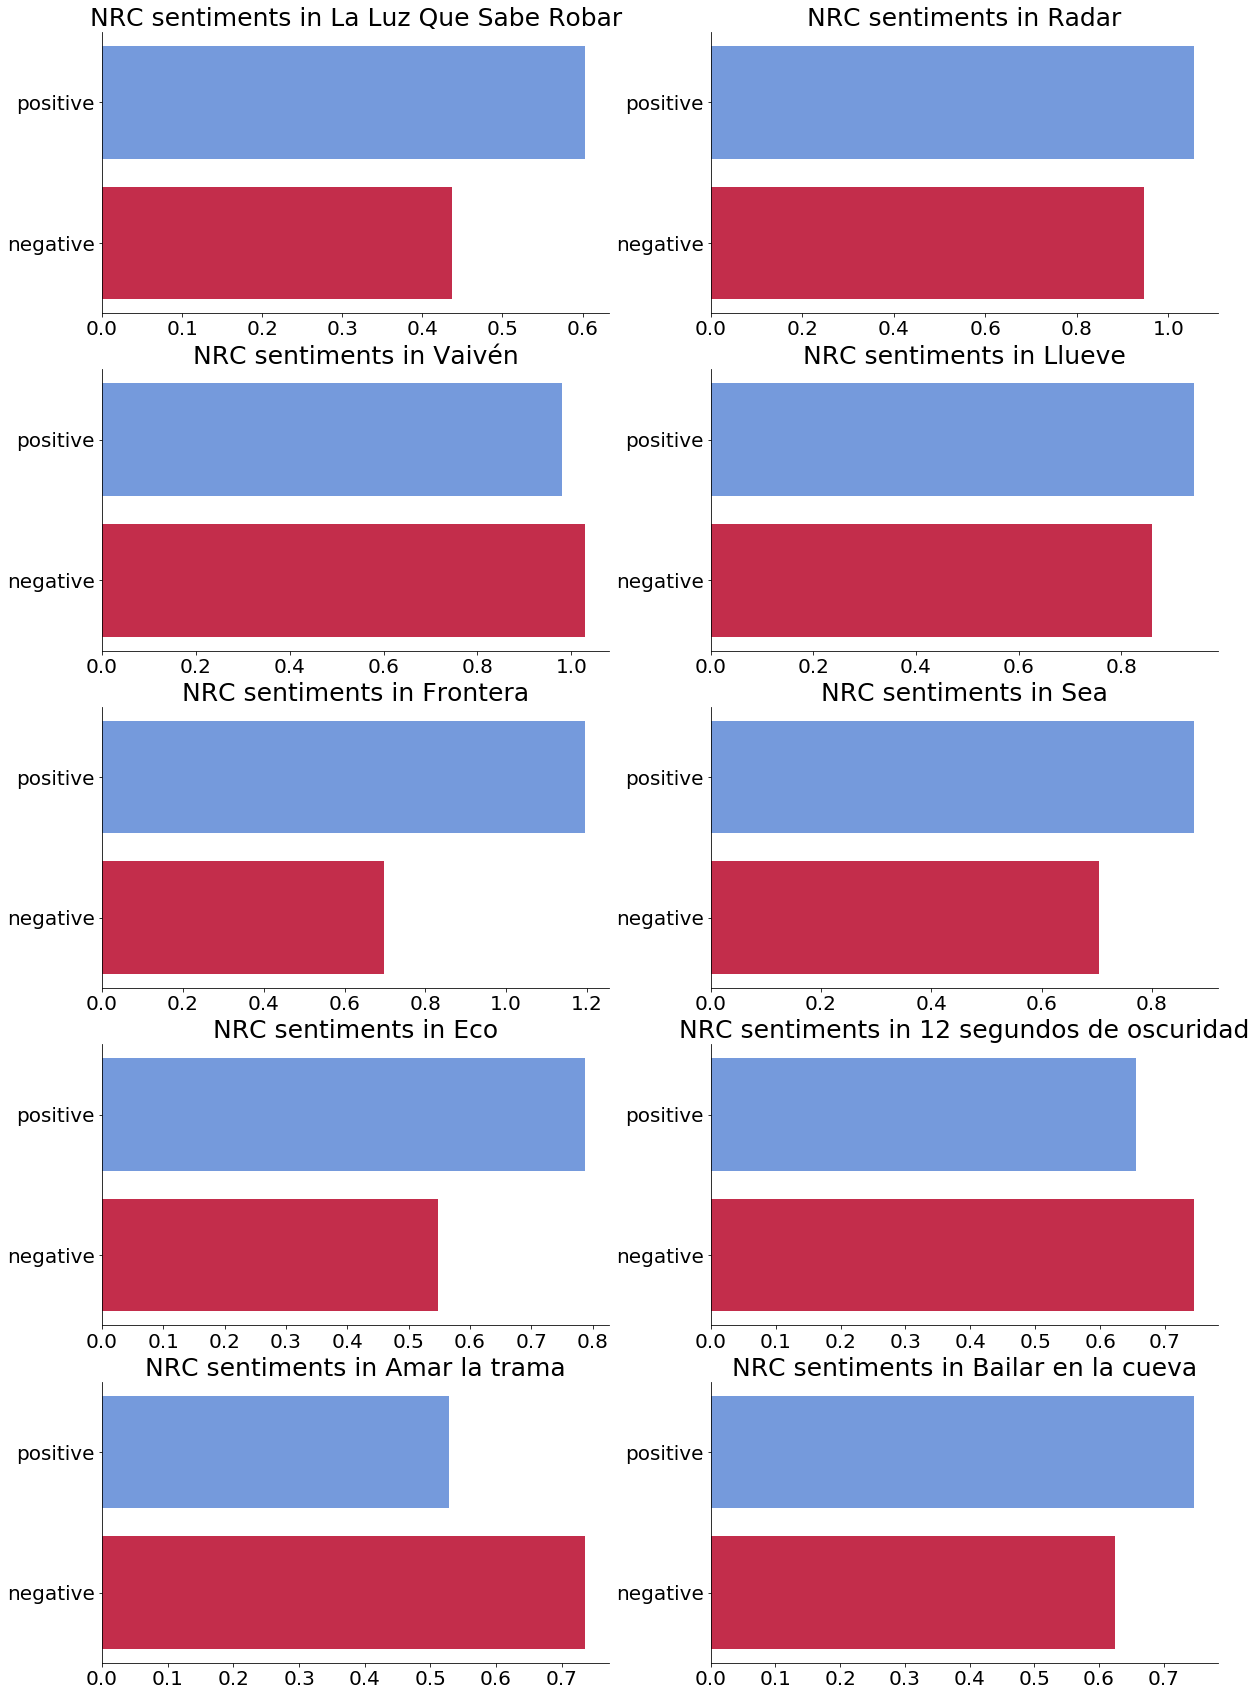

In [53]:
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]

ROWS = 5
COLS = 2
cols_to_iterate = albums_ordered_by_year
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        an_album = cols_to_iterate.pop(0)
        
        total_sentiments = pd.DataFrame(df[df['album'] == an_album].sum()[['positive', 'negative']])
        total_sentiments.columns = ['value']
        sns.barplot(
            y=total_sentiments.index, 
            x='value', 
            orient='h', 
            data=total_sentiments, 
            ax=axes[row, col], 
            #hue=total_sentiments.index,
            palette=colormap
        )

        axes[row, col].set_title('NRC sentiments in %s' % an_album, fontsize=25)
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
plt.show()


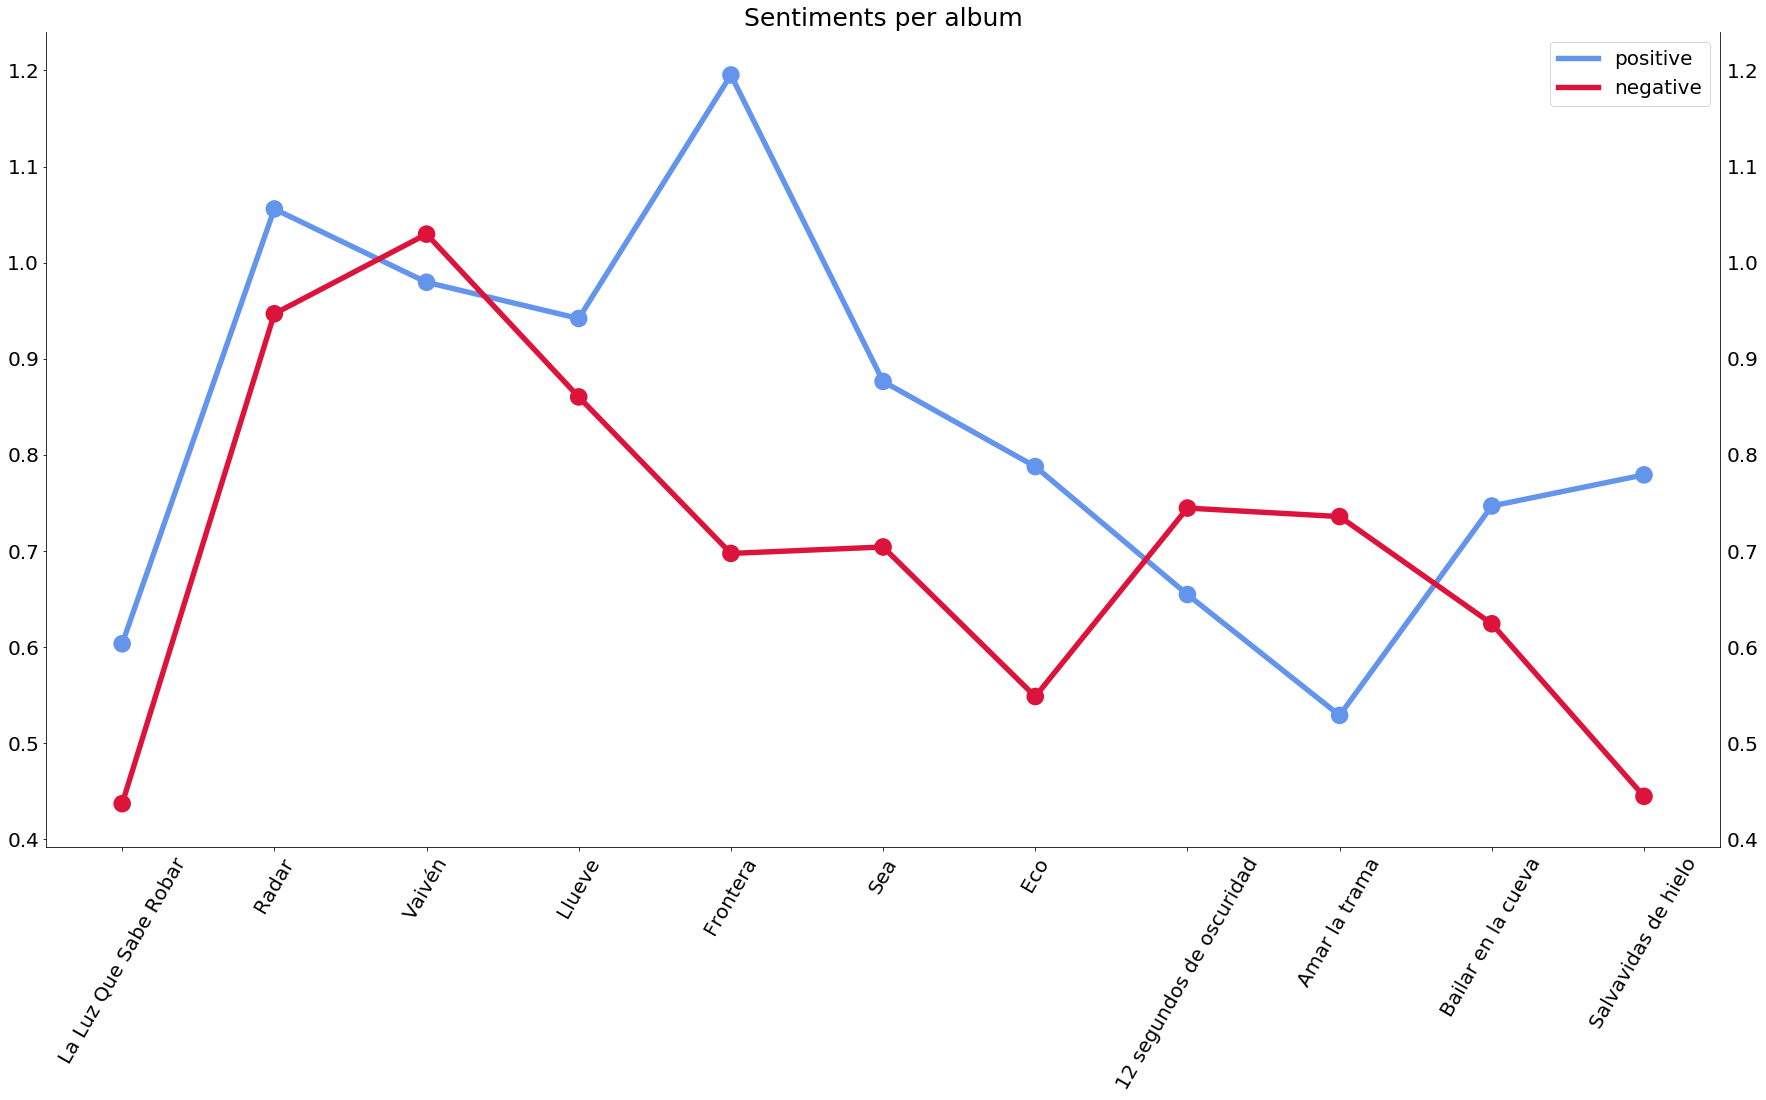

In [54]:
fig, ax = plt.subplots(figsize=(30,15))
for a_sentiment in sentiments:
    sns.pointplot(x="album", y=a_sentiment, data=albums_by_emotion, color=colormap[a_sentiment], scale=2,)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=20)
ax.set_title("Sentiments per album", fontdict={'fontsize': 25})
plt.ylabel("")
plt.xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax.legend(handles=ax.lines[::len(albums_by_emotion)+1], labels=sentiments, prop={'size': 20})
plt.show();

In [61]:
spoti_df = df[['name', 'album', 'acousticness', 'danceability', 'energy', 'key', 'tempo',
       'time_signature', 'valence', 'mode']]
spoti_df[df['time_signature']==5]

,name,album,acousticness,danceability,energy,key,tempo,time_signature,valence,mode
index,,,,,,,,,,
5,Asilo,Salvavidas de hielo,0.808,0.502,0.239,0.0,127.484,5.0,0.367,1.0


In [65]:
spoti_df.loc[5, 'time_signature'] = 3.0

/Users/alex/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [67]:
spoti_df[df['time_signature']==1]

,name,album,acousticness,danceability,energy,key,tempo,time_signature,valence,mode
index,,,,,,,,,,
77,Alto El Fuego,Frontera,0.898,0.655,0.162,2.0,82.264,1.0,0.649,1.0


In [68]:
spoti_df.loc[77, 'time_signature'] = 3.0

/Users/alex/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [76]:
spoti_df.head()

,name,album,acousticness,danceability,energy,key,tempo,time_signature,valence,mode
index,,,,,,,,,,
0,Movimiento,Salvavidas de hielo,0.900,0.784,0.457,2.0,125.021,4.0,0.546,1.0
1,Telefonía,Salvavidas de hielo,0.829,0.915,0.592,6.0,126.060,4.0,0.841,0.0
2,Silencio,Salvavidas de hielo,0.263,0.887,0.568,4.0,127.923,4.0,0.127,0.0
3,Pongamos que hablo de Martínez,Salvavidas de hielo,0.893,0.849,0.458,9.0,119.950,4.0,0.461,1.0
4,Estalactitas,Salvavidas de hielo,0.797,0.772,0.630,0.0,136.019,4.0,0.909,1.0


In [72]:
spoti_df.tempo.describe()

count    131.000000
mean     121.672885
std       27.364699
min       63.705000
25%      101.973000
50%      124.974000
75%      139.971500
max      192.012000
Name: tempo, dtype: float64

Mean for tempo is 122. Max is 192 and min is 64.

In [73]:
spoti_df[spoti_df['tempo'] == 192.012000]

,name,album,acousticness,danceability,energy,key,tempo,time_signature,valence,mode
index,,,,,,,,,,
18,La plegaria del paparazzo,Bailar en la cueva,0.0492,0.665,0.731,6.0,192.012,4.0,0.732,1.0


In [74]:
spoti_df[spoti_df['tempo'] == 63.705000]

,name,album,acousticness,danceability,energy,key,tempo,time_signature,valence,mode
index,,,,,,,,,,
41,Hermana duda,12 segundos de oscuridad,0.126,0.305,0.627,7.0,63.705,4.0,0.411,1.0


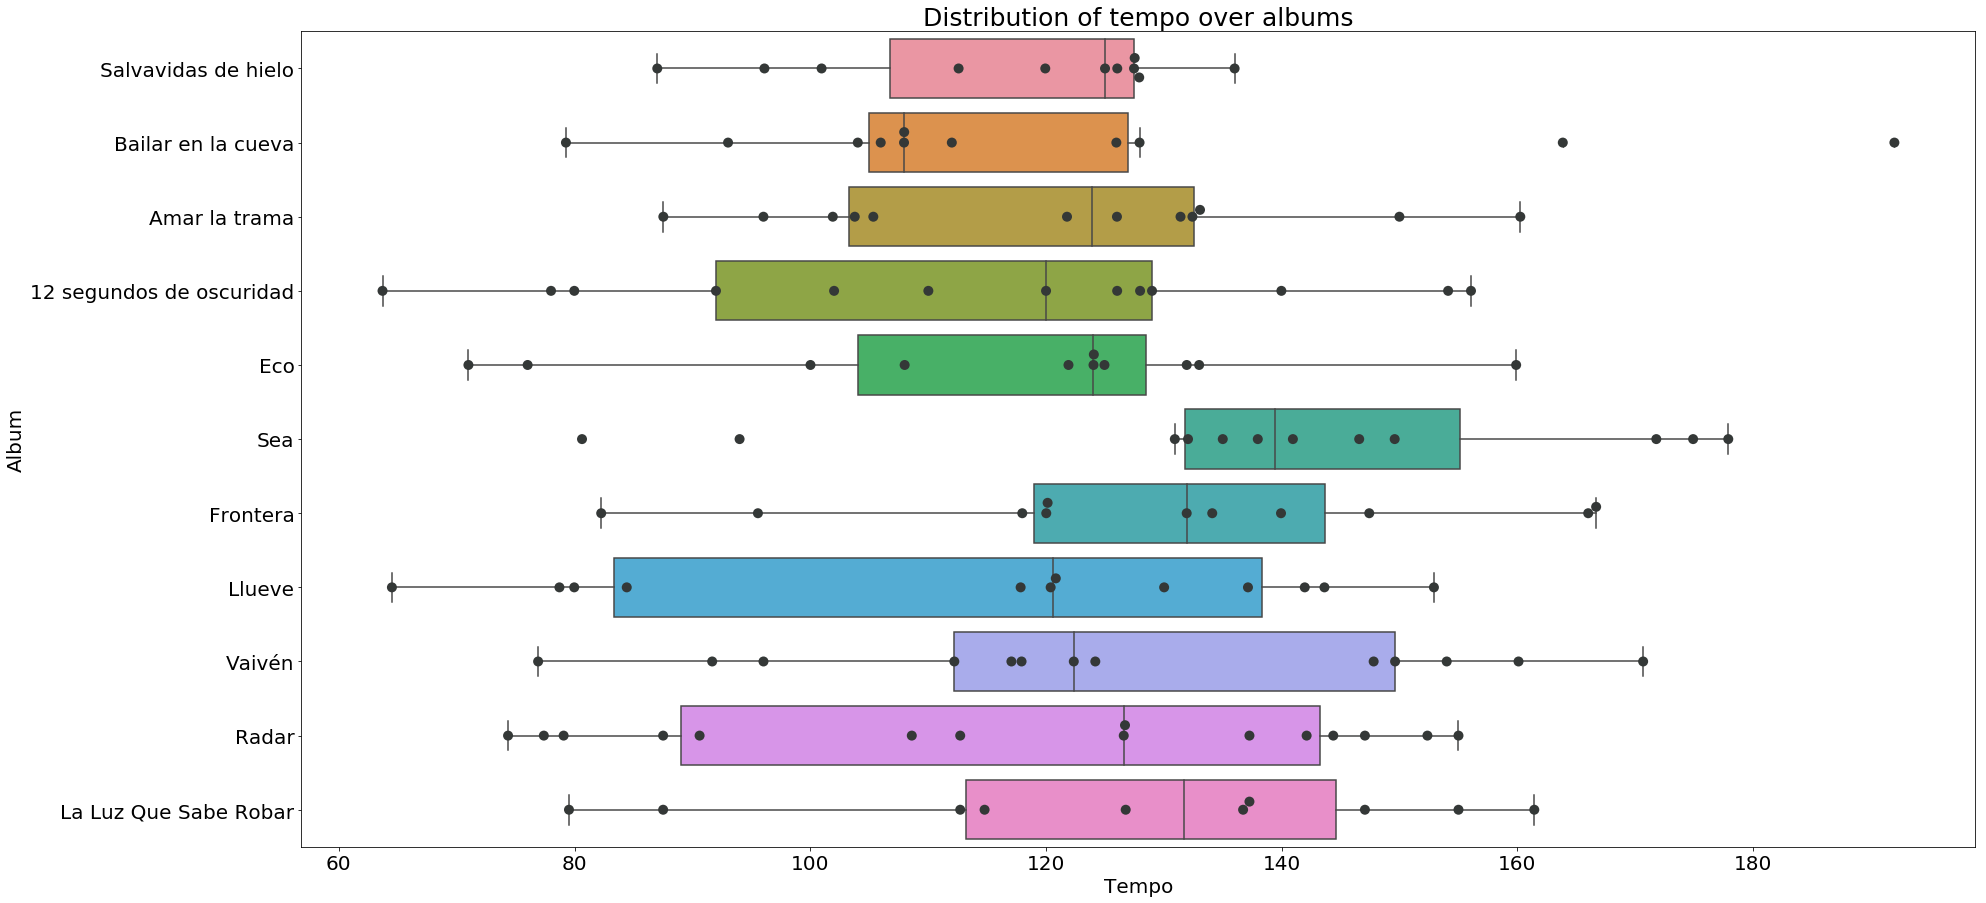

In [69]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="tempo", y="album", data=spoti_df, orient='h')
ax = sns.swarmplot(x="tempo", y="album", data=spoti_df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Tempo', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of tempo over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

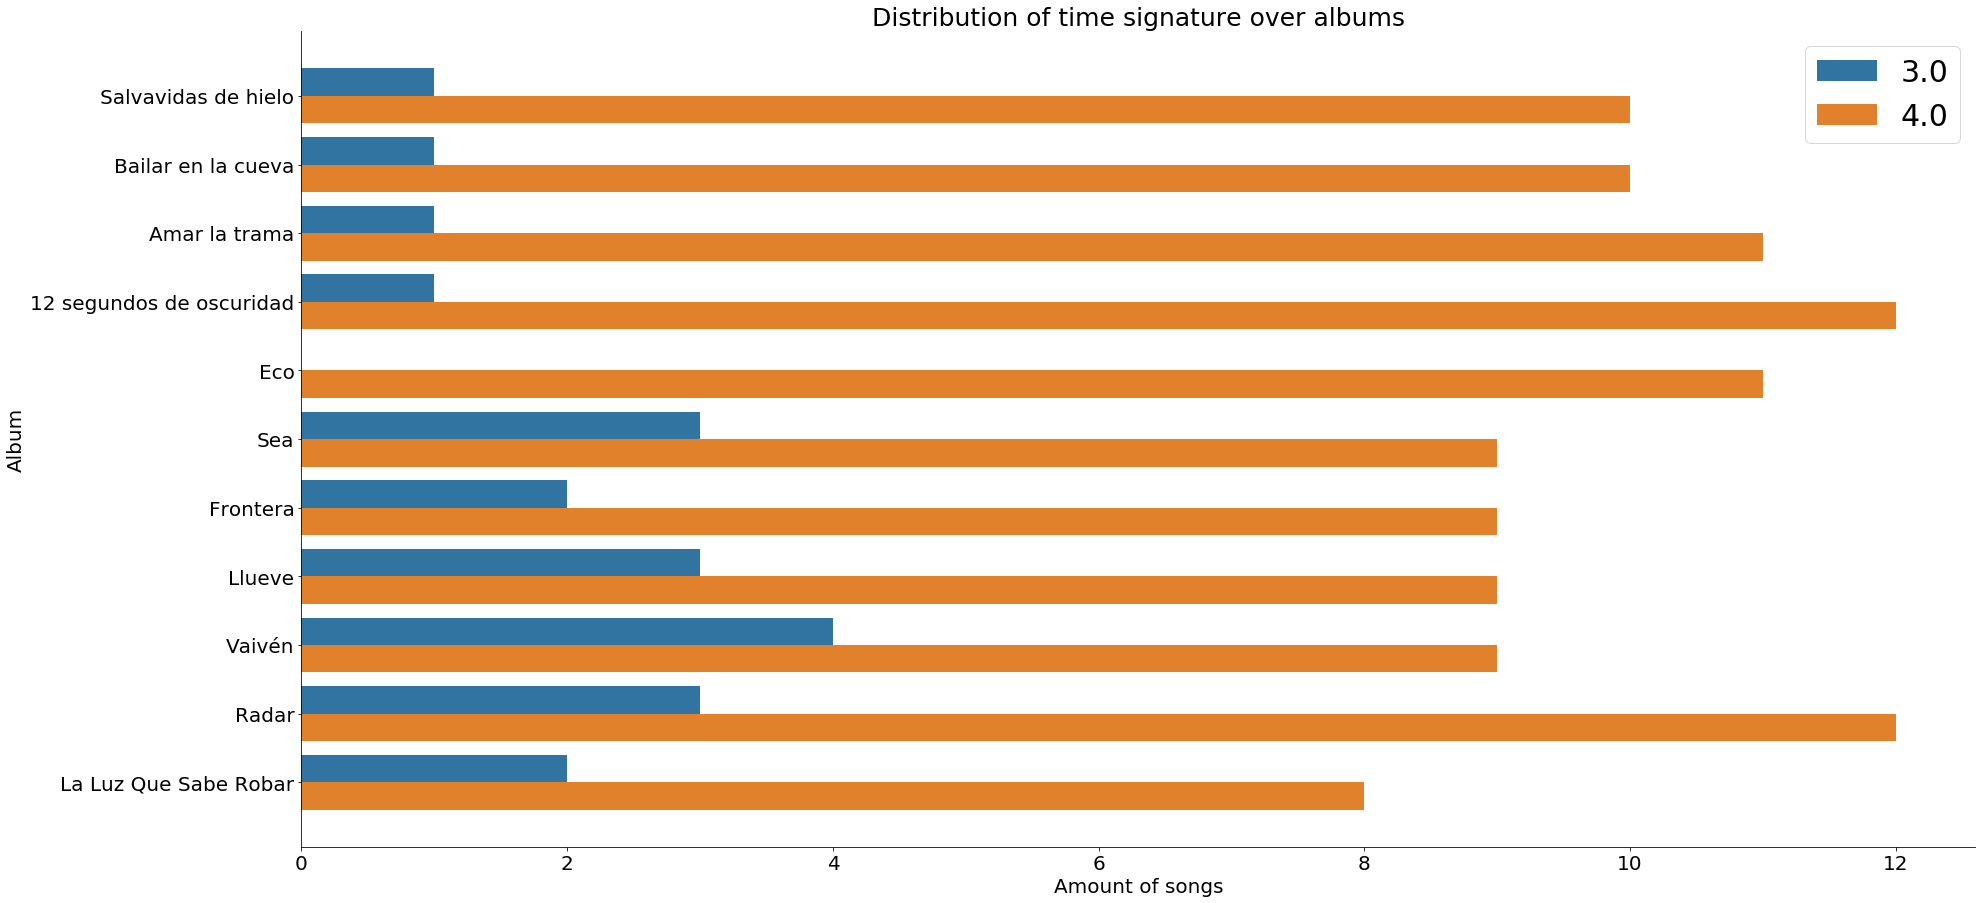

In [85]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.countplot(y="album", orient='h', hue="time_signature", data=spoti_df)
plt.xlabel('Amount of songs', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of time signature over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
ax.legend(prop={'size': 30})
plt.plot();

### From spotify api
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

Let's make a real key feature

In [86]:
keymap = {0: 'C', 1: 'Db', 2: 'D', 3: 'Eb',
          4:'E', 5:'F', 6:'F#', 7:'G', 8:'Ab',
          9:'A', 10:'Bb', 11:'B'}

In [93]:
df['real_key'] = df.key.map(keymap)
for index, row in df.iterrows():
    if not row['mode']:
        df.at[index, 'real_key'] = row['real_key'] + 'm'        
        #Major is represented by 1 and minor is 0.

In [95]:
spoti_df['real_key'] = df['real_key']

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


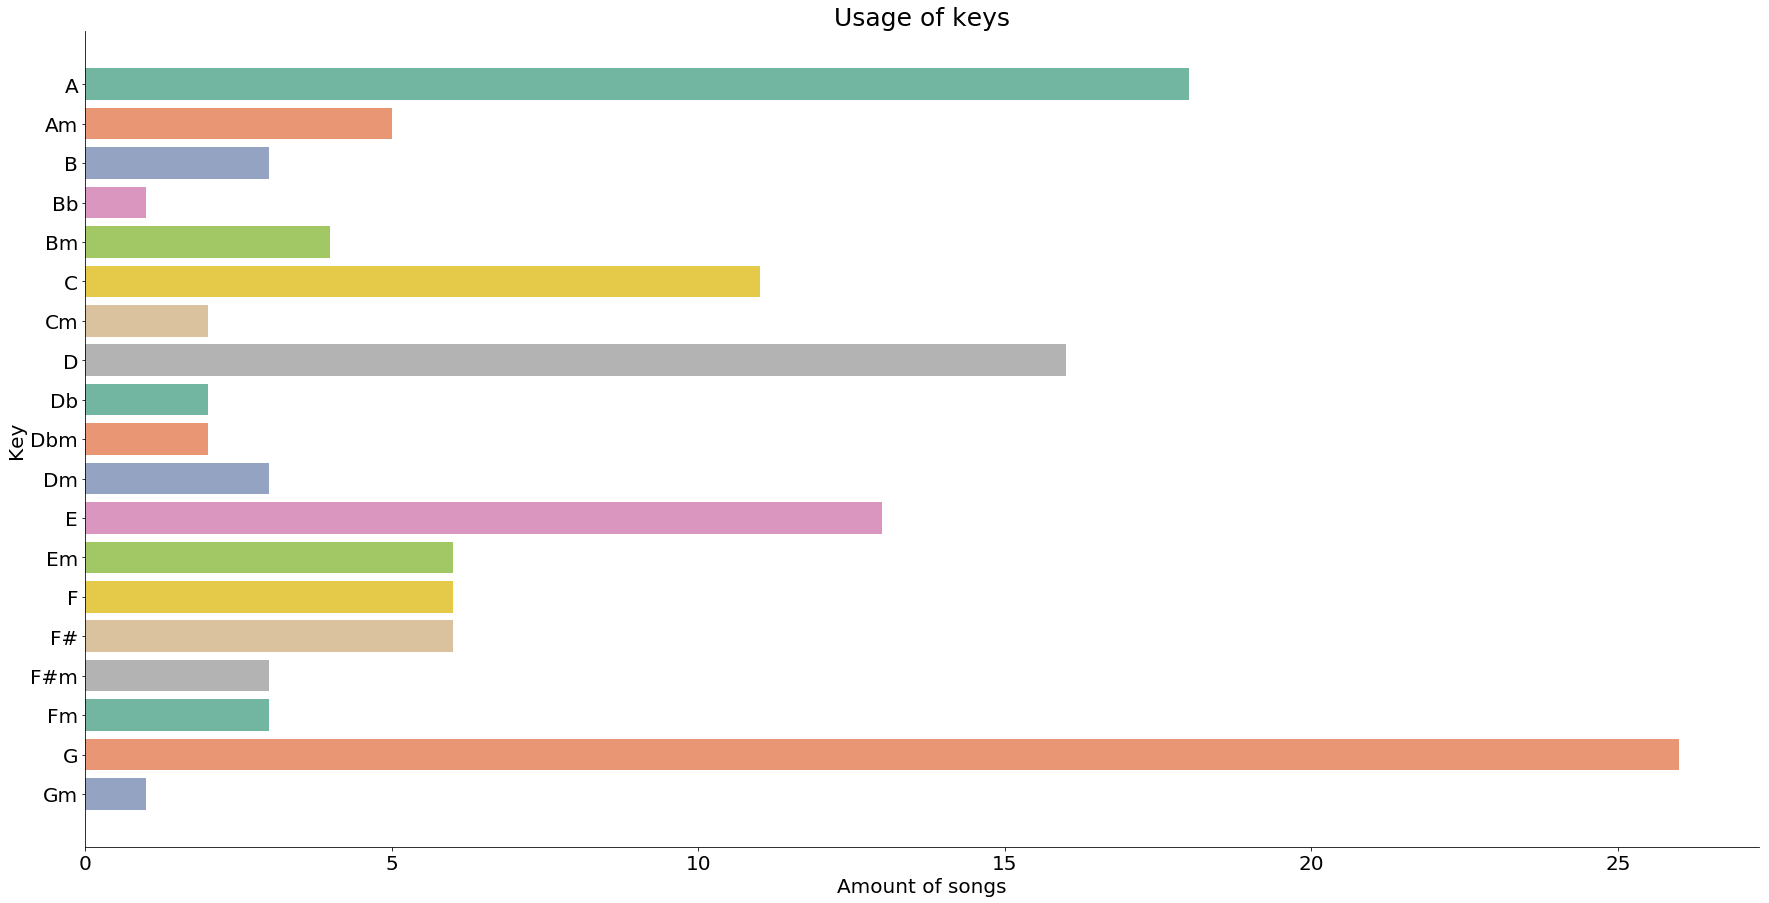

In [109]:
fig, ax = plt.subplots(figsize=(30,15))
order = sorted(spoti_df.real_key.unique())
ax = sns.countplot(y="real_key", orient='h', data=spoti_df, order=order, palette="Set2")
plt.xlabel('Amount of songs', fontsize=20)
plt.ylabel('Key', fontsize=20)
plt.title('Usage of keys', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
plt.plot();


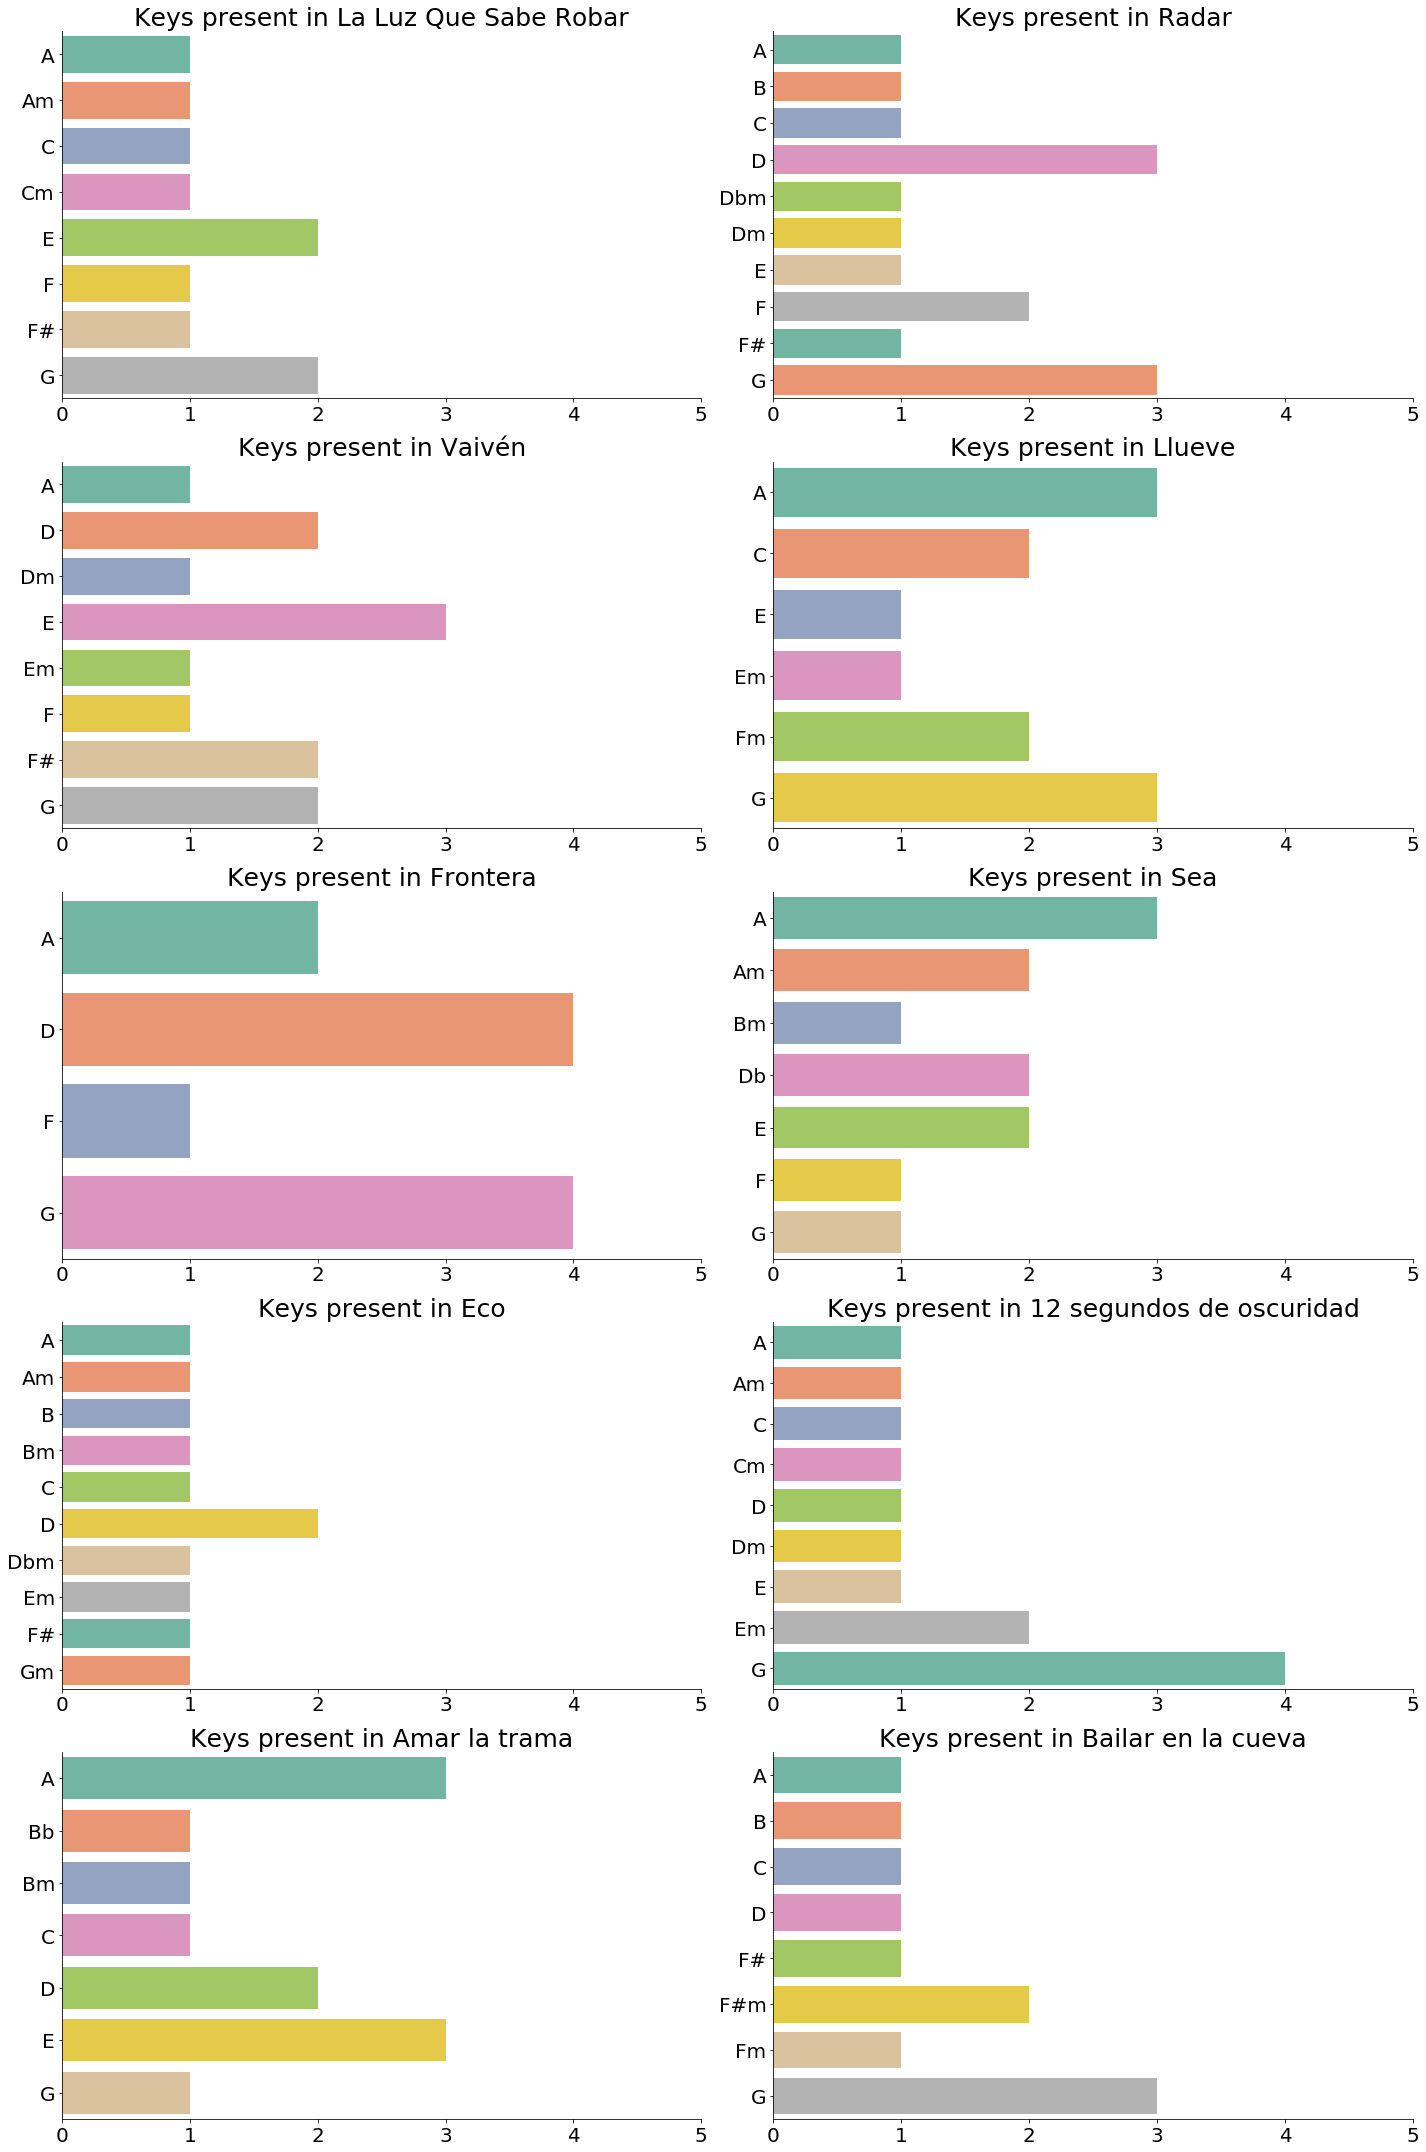

In [117]:
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]

ROWS = 5
COLS = 2
cols_to_iterate = albums_ordered_by_year
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        an_album = cols_to_iterate.pop(0)
        
        key_by_album = pd.DataFrame(spoti_df[spoti_df['album'] == an_album])
        order = sorted(key_by_album.real_key.unique())
        ax = sns.countplot(y="real_key", orient='h', data=key_by_album, ax=axes[row, col], order=order, palette="Set2")
        
        axes[row, col].set_xticks([0,1,2,3,4,5])
        axes[row, col].set_title('Keys present in %s' % an_album, fontsize=25)
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)

        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
plt.tight_layout()
plt.show()


# Last step! Saddest and happiest song?

https://www.rcharlie.com/post/fitter-happier/

In [127]:
df.sort_values(by='valence', ascending=False).head()[['name', 'valence']]

,name,valence
index,,
100,Un Lugar En Tu Almohada,0.950
7,Mandato,0.937
61,Horas,0.924
60,Causa Y Efecto,0.920
4,Estalactitas,0.909


In [128]:
df.sort_values(by='valence').head()[['name', 'valence']]

,name,valence
index,,
34,12 segundos de oscuridad,0.0396
83,Llueve,0.0765
21,Organdí,0.1060
2,Silencio,0.1270
8,Despedir a los glaciares,0.1430


joy and sadness percentage

In [141]:
for index, row in df.iterrows():    
    try:
        to_lower = list(map(lambda x:x.lower(),df.loc[index].tokens))
        annotation = lexicon.annotate_doc(to_lower)
        count_sadness = 0
        count_joy = 0
        for a_set in annotation:
            if 'sadness' in a_set:
                count_sadness +=1
            if 'joy' in a_set:
                count_joy +=1
        df.at[index, 'sadness_per'] = count_sadness / len(annotation)        
        df.at[index, 'joy_per'] = count_joy / len(annotation)        
    except:
        continue

In [143]:
df.sort_values(by='sadness_per').head()[['name', 'sadness_per']]

,name,sadness_per
index,,
65,Me Haces Bien,0.0
51,Transporte,0.0
59,Sea,0.0
129,Macarena y el espejo,0.0
66,Durante,0.0


In [146]:
df.sort_values(by='sadness_per', ascending=False).head()[['name', 'sadness_per']]

,name,sadness_per
index,,
27,Toque de queda,0.127907
98,Ganas De Ti,0.116667
75,Madre Tierra,0.111111
61,Horas,0.108333
103,Dos Colores: Blanco Y Negro,0.103448


$$ gloom\_index = \frac{(1 - valence) + sadness\_per * (1 + ly_d)}{2}$$

In [177]:
df['gloom_index'] = ((1 - df['valence']) + df['sadness_per'] * (1 + df['ly_d']) ) / 2

In [179]:
# Create x, where x the 'scores' column's values as floats
x = df[['gloom_index']].fillna(0).values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,100))

# Create an object to transform the data to fit minmax processor
df['gloom_index'] = min_max_scaler.fit_transform(x)

In [175]:
df.sort_values(by='gloom_index', ascending=False).head()[['name', 'gloom_index']]

,name,gloom_index
index,,
34,12 segundos de oscuridad,100.000000
8,Despedir a los glaciares,86.083937
83,Llueve,85.760917
87,Cara B,85.351075
21,Organdí,84.602588


$$ brightness\_index = \frac{(1 - valence) + joy\_per * (1 + ly_d)}{2}$$

In [ ]:
df['gloom_index'] = ((1 - df['valence']) + df['sadness_per'] * (1 + df['ly_d']) ) / 2

In [ ]:
# Create x, where x the 'scores' column's values as floats
x = df[['gloom_index']].fillna(0).values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,100))

# Create an object to transform the data to fit minmax processor
df['gloom_index'] = min_max_scaler.fit_transform(x)

In [ ]:
# Create x, where x the 'scores' column's values as floats
x = df[['gloom_index']].fillna(0).values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,100))

# Create an object to transform the data to fit minmax processor
df['gloom_index'] = min_max_scaler.fit_transform(x)